In [108]:
import pandas as pd
import numpy as np

from datetime import datetime

import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
import datetime

import math
import seaborn as sns
import scipy.stats as stats

from shapely.geometry import Point, LineString, Polygon

import geopandas as gpd

In [2]:
spray = pd.read_csv('../predict-west-nile-virus/spray.csv')

i'm just going through a preliminary overview of the spray dataset..

In [3]:
spray.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [4]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [5]:
pandas_profiling.ProfileReport(spray)

In [12]:
# create another copy of spray to work on
spray1 = spray.copy()

### Handling null values and duplicates

Examine spray dataset for null values

In [13]:
spray1[spray1.isna().any(axis=1)].head()

Date Time   Latitude  Longitude
1030  7/9/2011  NaN  41.987092 -87.794286
1031  7/9/2011  NaN  41.987620 -87.794382
1032  7/9/2011  NaN  41.988004 -87.794574
1033  7/9/2011  NaN  41.988292 -87.795486
1034  7/9/2011  NaN  41.988100 -87.796014

Looks like `Time` is the main source of NaN cells? Let's check if other columns have NaN

In [14]:
spray1.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

We've confirmed that all the null rows were caused by missing data for `Time`. Time data is probably too finely tuned for our needs, so we might drop `Time` from spray instead. 

But first, we want to explore our duplicate spray rows.

In [15]:
# looking at our dupes
spray1[spray1.duplicated(keep=False)].head(20)

Date        Time   Latitude  Longitude
484  7/9/2011  7:43:40 PM  41.983917 -87.793088
485  7/9/2011  7:43:40 PM  41.983917 -87.793088
489  7/9/2011  7:44:32 PM  41.986460 -87.794225
490  7/9/2011  7:44:32 PM  41.986460 -87.794225
491  7/9/2011  7:44:32 PM  41.986460 -87.794225
492  7/9/2011  7:44:32 PM  41.986460 -87.794225
493  7/9/2011  7:44:32 PM  41.986460 -87.794225
494  7/9/2011  7:44:32 PM  41.986460 -87.794225
495  7/9/2011  7:44:32 PM  41.986460 -87.794225
496  7/9/2011  7:44:32 PM  41.986460 -87.794225
497  7/9/2011  7:44:32 PM  41.986460 -87.794225
498  7/9/2011  7:44:32 PM  41.986460 -87.794225
499  7/9/2011  7:44:32 PM  41.986460 -87.794225
500  7/9/2011  7:44:32 PM  41.986460 -87.794225
501  7/9/2011  7:44:32 PM  41.986460 -87.794225
502  7/9/2011  7:44:32 PM  41.986460 -87.794225
503  7/9/2011  7:44:32 PM  41.986460 -87.794225
504  7/9/2011  7:44:32 PM  41.986460 -87.794225
505  7/9/2011  7:44:32 PM  41.986460 -87.794225
506  7/9/2011  7:44:32 PM  41.986460 -87.794225

It's not clear from the data dictonary from Kaggle why there are duplicate records for spray, down to the exact timing. Perhaps multiple rows are meant to indicate the number of times a location was sprayed on one day, to serve as a proxy for total dosage?

In [16]:
# examing one of the records that have a lot of duplicates
spray1.loc[(spray1["Date"] == "2011-09-07") & (spray1["Latitude"]==41.986460) & (spray1["Longitude"]==-87.794225)]

Empty DataFrame
Columns: [Date, Time, Latitude, Longitude]
Index: []

With that, we've established that duplicates in spray are purely the result of data collection error, so we can safely drop those rows.

We're going to:
* drop `Time`
* drop duplicate rows

In [17]:
spray1 = spray1.drop(columns=["Time"])
spray1.head()

Date   Latitude  Longitude
0  29/8/2011  42.391623 -88.089163
1  29/8/2011  42.391348 -88.089163
2  29/8/2011  42.391022 -88.089157
3  29/8/2011  42.390637 -88.089158
4  29/8/2011  42.390410 -88.088858

In [18]:
print(f"Spray shape before drop: {spray1.shape}")
spray1 = spray1.drop_duplicates(keep='first')
print(f"New spray shape: {spray1.shape}")

Spray shape before drop: (14835, 3)
New spray shape: (14294, 3)


Now, to find out 
* number of unique spray dates 
* number of sprays made on each unique date

In [19]:
print(spray1["Date"].nunique())
spray1["Date"].value_counts()

10


15/8/2013    2668
29/8/2013    2302
17/7/2013    2202
25/7/2013    1607
22/8/2013    1587
7/9/2011     1573
8/8/2013     1195
5/9/2013      924
16/8/2013     141
29/8/2011      95
Name: Date, dtype: int64

In [67]:
# Set Y (capitalise) so year is clearly understood to be 4 digits 
# spray['Date'] = pd.to_datetime(spray['Date'], format='%Y-%m-%d')

spray1['Date'] = pd.to_datetime(spray1.Date)

In [ ]:
# spray.set_index('Date', inplace=True)

In [70]:
spray1.head()

Date   Latitude  Longitude
0 2011-08-29  42.391623 -88.089163
1 2011-08-29  42.391348 -88.089163
2 2011-08-29  42.391022 -88.089157
3 2011-08-29  42.390637 -88.089158
4 2011-08-29  42.390410 -88.088858

In [71]:
spray1.dtypes

Date         datetime64[ns]
Latitude            float64
Longitude           float64
dtype: object

In [72]:
# Earliest collection
print(spray1['Date'].min())
# Latest collection
print(spray1['Date'].max())

2011-07-09 00:00:00
2013-08-29 00:00:00


In [73]:
spray1.dtypes.value_counts()

float64           2
datetime64[ns]    1
dtype: int64

In [74]:
# New columns for Year, Month, Day in DataFrame 
spray1['Year'] = spray1['Date'].dt.year
spray1['Month'] = spray1['Date'].dt.month
spray1['Day'] = spray1['Date'].dt.day

In [ ]:
## make datetime columns
# spray['Year'] = spray['Date'].apply(lambda x:x.year)
# spray['Month'] = spray['Date'].apply(lambda x:x.month)
# spray['WeekofYear'] = spray['Date'].apply(lambda x:x.weekofyear)
# spray['YearMonth'] = spray['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

# # year 2007 - 2013
# print(spray.Year.value_counts().sort_index())

# # data only from may - oct
# print(spray.Month.value_counts())

# # week 22 - 41
# print(spray.WeekofYear.value_counts().sort_index())

# # total number of weeks in dataset
# print(spray.WeekofYear.nunique())

In [75]:
spray1.head()

Date   Latitude  Longitude  Year  Month  Day
0 2011-08-29  42.391623 -88.089163  2011      8   29
1 2011-08-29  42.391348 -88.089163  2011      8   29
2 2011-08-29  42.391022 -88.089157  2011      8   29
3 2011-08-29  42.390637 -88.089158  2011      8   29
4 2011-08-29  42.390410 -88.088858  2011      8   29

In [76]:
spray1.isnull().sum()
# spray['Time'].isnull().sum()

Date         0
Latitude     0
Longitude    0
Year         0
Month        0
Day          0
dtype: int64

In [78]:
#spray1['Time'].unique()
# there should be anymore time values as it has been removed

In [79]:
round(spray1['Longitude'],1).value_counts()

-87.7    6814
-87.8    5798
-87.6    1582
-88.1      95
-87.9       5
Name: Longitude, dtype: int64

In [80]:
round(spray1['Latitude'],1).value_counts()

42.0    5439
41.9    5001
41.7    2318
41.8    1441
42.4      95
Name: Latitude, dtype: int64

In [81]:
spray1.head()

Date   Latitude  Longitude  Year  Month  Day
0 2011-08-29  42.391623 -88.089163  2011      8   29
1 2011-08-29  42.391348 -88.089163  2011      8   29
2 2011-08-29  42.391022 -88.089157  2011      8   29
3 2011-08-29  42.390637 -88.089158  2011      8   29
4 2011-08-29  42.390410 -88.088858  2011      8   29

In [86]:
np.unique(spray1['Date'])

array(['2011-07-09T00:00:00.000000000', '2011-08-29T00:00:00.000000000',
       '2013-05-09T00:00:00.000000000', '2013-07-17T00:00:00.000000000',
       '2013-07-25T00:00:00.000000000', '2013-08-08T00:00:00.000000000',
       '2013-08-15T00:00:00.000000000', '2013-08-16T00:00:00.000000000',
       '2013-08-22T00:00:00.000000000', '2013-08-29T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [90]:
spray1[['Latitude','Longitude']].describe()

Latitude     Longitude
count  14294.000000  14294.000000
mean      41.901739    -87.734512
std        0.105100      0.067599
min       41.713925    -88.096468
25%       41.782669    -87.789607
50%       41.937578    -87.724781
75%       41.977217    -87.692107
max       42.395983    -87.586727

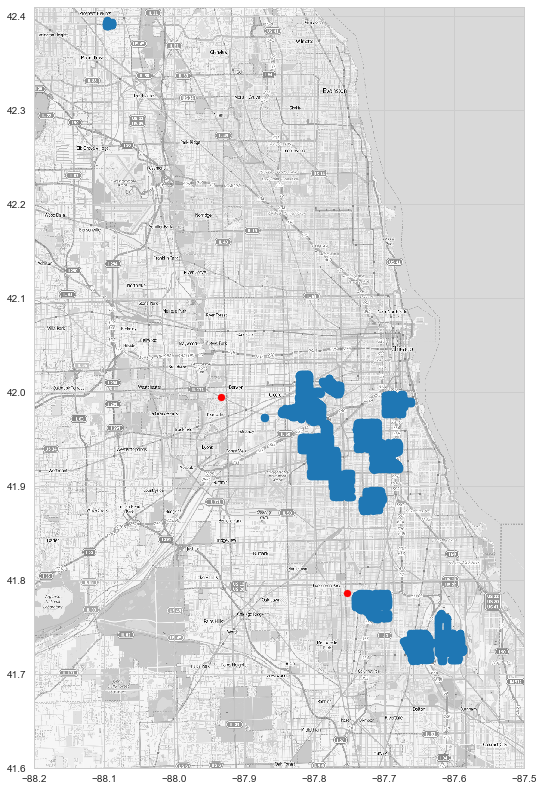

In [91]:
mapdata = np.loadtxt("./data/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88.2, -87.5, 41.6, 42.41)

plt.figure(figsize=(12,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('Greys_r'), 
           extent=lon_lat_box, 
           aspect=aspect)

# locations = aggregated[['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter([-87.933,-87.752],[41.995,41.786], marker = 'o', c='red')
plt.scatter(spray1.Longitude, spray1.Latitude ,marker = 'o')

In [92]:
s1 = spray1[spray1['Date'] == '15/8/2013']
s1.head()

Date   Latitude  Longitude  Year  Month  Day
7213 2013-08-15  41.944718 -87.808187  2013      8   15
7214 2013-08-15  41.944125 -87.808177  2013      8   15
7215 2013-08-15  41.943768 -87.808162  2013      8   15
7216 2013-08-15  41.943405 -87.808153  2013      8   15
7217 2013-08-15  41.942983 -87.808135  2013      8   15

In [47]:
# defining a function to find midpoint of a cluster
def centroid(points):
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    _len = len(points)
    centroid_x = sum(x_coords)/_len
    centroid_y = sum(y_coords)/_len
    return [centroid_x, centroid_y]

In [152]:
# defining a function to find midpoint of a cluster
def centroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return (sum_x/length, sum_y/length)

In [153]:
centroid(s1[['Latitude','Longitude']].values)

(41.926006612305095, -87.78317114249626)

In [154]:
midpoint_dict = {}
for i in spray1.Date.unique():
    si = spray1[spray1['Date'] == i]
    si[['Latitude','Longitude']].values
    midpoint = centroid(si[['Latitude','Longitude']].values)
    midpoint_dict[i] = midpoint
    
midpoint_dict

{datetime.date(2011, 8, 29): (42.39233059621053, -88.0933703683158),
 datetime.date(2011, 7, 9): (41.98227395945963, -87.80995275699301),
 datetime.date(2013, 7, 17): (41.798570333805635, -87.68113743704359),
 datetime.date(2013, 7, 25): (41.95453456542004, -87.72287901894214),
 datetime.date(2013, 8, 8): (41.931466280284525, -87.69703514644353),
 datetime.date(2013, 8, 15): (41.926006612305095, -87.78317114249626),
 datetime.date(2013, 8, 16): (41.95780932602837, -87.78064648957447),
 datetime.date(2013, 8, 22): (41.81405241138627, -87.66602854978576),
 datetime.date(2013, 8, 29): (41.86012774764553, -87.70323708733709),
 datetime.date(2013, 5, 9): (42.00543551040043, -87.81308488086579)}

In [155]:
spray1['midpoint'] = spray1['Date'].map(midpoint_dict)
spray1[['midpt_Lat','midpt_Lon']] = pd.DataFrame(spray1.midpoint.values.tolist(), index = spray1.index)

In [156]:
spray1.head()

Date   Latitude  Longitude  Year  Month  Day  \
0  2011-08-29  42.391623 -88.089163  2011      8   29   
1  2011-08-29  42.391348 -88.089163  2011      8   29   
2  2011-08-29  42.391022 -88.089157  2011      8   29   
3  2011-08-29  42.390637 -88.089158  2011      8   29   
4  2011-08-29  42.390410 -88.088858  2011      8   29   

                                 midpoint  midpt_Lat  midpt_Lon  Station  \
0  (42.39233059621053, -88.0933703683158)  42.392331  -88.09337        1   
1  (42.39233059621053, -88.0933703683158)  42.392331  -88.09337        1   
2  (42.39233059621053, -88.0933703683158)  42.392331  -88.09337        1   
3  (42.39233059621053, -88.0933703683158)  42.392331  -88.09337        1   
4  (42.39233059621053, -88.0933703683158)  42.392331  -88.09337        1   

                     geometry                               Coord YearMonth  \
0  POINT (-88.09337 42.39233)         (42.39162333, -88.08916333)   2011-08   
1  POINT (-88.09337 42.39233)         (42.39134833, -88.08916333)   2011-08   
2  POINT (-88.09337 42.39233)         (42.39102167, -88.08915667)   2011-08   
3  POINT (-88.09337 42.39233)         (42.39063667, -88.08915833)   2011-08   
4  POINT (-88.09337 42.39233)  (42.390409999999996, -88.08885833)   2011-08   

   Week  
0    35  
1    35  
2    35  
3    35  
4    35

In [157]:
# function to calculate distance between 2 lat/long points
# source: http://www.johndcook.com/blog/python_longitude_latitude/
def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to spherical coordinates in radians
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

# weather stations 1 and 2 lat/longitude
station_1_lat = 41.995
station_1_lon = -87.933
station_2_lat = 41.786
station_2_lon = -87.752

# function to calculate whether station 1 or 2 (from weather.csv) is closer
def closest_station(lat, lon):
    if (distance_on_unit_sphere(lat, lon, station_1_lat, station_1_lon) <
        distance_on_unit_sphere(lat, lon, station_2_lat, station_2_lon)):
        return 1
    else: return 2

# add station to indicate whether station 1 or 2 is closer
spray1['Station'] = [closest_station(a,b) for (a, b) in zip(spray1.midpt_Lat, spray1.midpt_Lon)]

spray1.Station.value_counts()

2    7286
1    7008
Name: Station, dtype: int64

In [158]:
spray1.head()

Date   Latitude  Longitude  Year  Month  Day  \
0  2011-08-29  42.391623 -88.089163  2011      8   29   
1  2011-08-29  42.391348 -88.089163  2011      8   29   
2  2011-08-29  42.391022 -88.089157  2011      8   29   
3  2011-08-29  42.390637 -88.089158  2011      8   29   
4  2011-08-29  42.390410 -88.088858  2011      8   29   

                                 midpoint  midpt_Lat  midpt_Lon  Station  \
0  (42.39233059621053, -88.0933703683158)  42.392331  -88.09337        1   
1  (42.39233059621053, -88.0933703683158)  42.392331  -88.09337        1   
2  (42.39233059621053, -88.0933703683158)  42.392331  -88.09337        1   
3  (42.39233059621053, -88.0933703683158)  42.392331  -88.09337        1   
4  (42.39233059621053, -88.0933703683158)  42.392331  -88.09337        1   

                     geometry                               Coord YearMonth  \
0  POINT (-88.09337 42.39233)         (42.39162333, -88.08916333)   2011-08   
1  POINT (-88.09337 42.39233)         (42.39134833, -88.08916333)   2011-08   
2  POINT (-88.09337 42.39233)         (42.39102167, -88.08915667)   2011-08   
3  POINT (-88.09337 42.39233)         (42.39063667, -88.08915833)   2011-08   
4  POINT (-88.09337 42.39233)  (42.390409999999996, -88.08885833)   2011-08   

   Week  
0    35  
1    35  
2    35  
3    35  
4    35

In [159]:
# Export as CSV
spray1.to_csv('spray_clean.csv')

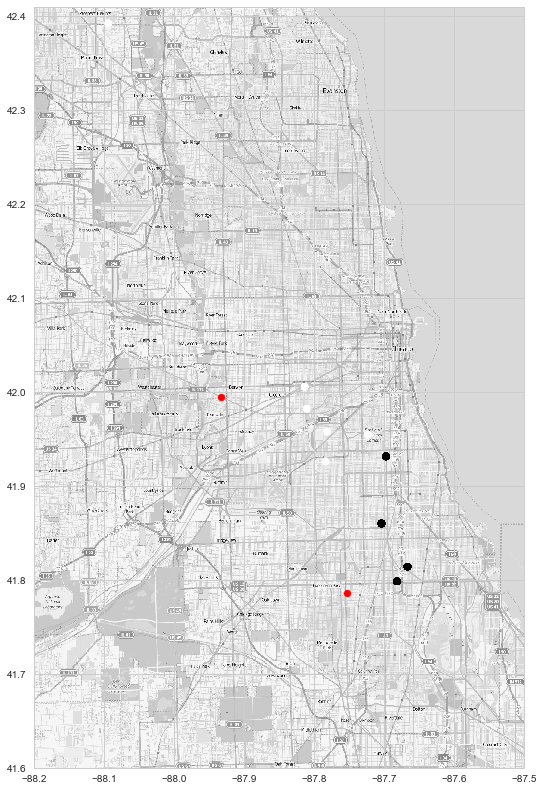

In [160]:
mapdata = np.loadtxt("./data/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88.2, -87.5, 41.6, 42.41)

plt.figure(figsize=(12,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('Greys_r'), 
           extent=lon_lat_box, 
           aspect=aspect)

# locations = aggregated[['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter([-87.933,-87.752],[41.995,41.786], marker = 'o', c='red')
plt.scatter(spray1.midpt_Lon, spray1.midpt_Lat ,marker = 'o', c = spray1.Station)

### Adding geographic and date features

In [109]:
# this function takes in a dataframe and returns a GeoPanda dataframe
# longitude and latitude columns will be formatted into geographic columns
# date columns will be formatted into datetime columns

def gpd_date(df): 
    
    # passing df into a GeoPanda
    
    # creating geometric point
    geom = [Point(xy) for xy in zip(df.midpt_Lon, df.midpt_Lat)]
    # creating a GeoPanda dataframe
    g_df = df.copy()
    g_df = gpd.GeoDataFrame(df, geometry=geom)

    # adding coordinates
    g_df["Coord"] = list(zip(g_df.Latitude, g_df.Longitude))
    
    # formatting `Date` column into a datetime column
    g_df["Date"] = pd.to_datetime(g_df["Date"],format='%Y-%m-%d')
    g_df['Date'] = g_df['Date'].dt.date
    
    # creating a `YearMonth` column for ease of comparison
    g_df['YearMonth'] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
    
    # creating a month column
    g_df["Year"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.year)).astype(int)
    
    # creating a month column
    g_df["Month"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.month)).astype(int)
    
    # creating a day column
    g_df["Day"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.day)).astype(int)
    
    # creating a week column
    g_df["Week"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.week)).astype(int)
    

    return g_df

In [110]:
g_spray = gpd_date(spray1)
g_spray.head()

Date   Latitude  Longitude  Year  Month  Day  \
0  2011-08-29  42.391623 -88.089163  2011      8   29   
1  2011-08-29  42.391348 -88.089163  2011      8   29   
2  2011-08-29  42.391022 -88.089157  2011      8   29   
3  2011-08-29  42.390637 -88.089158  2011      8   29   
4  2011-08-29  42.390410 -88.088858  2011      8   29   

                                   midpoint  midpt_Lat  midpt_Lon  Station  \
0  [42.392330596210535, -88.09337036831577]  42.392331  -88.09337        1   
1  [42.392330596210535, -88.09337036831577]  42.392331  -88.09337        1   
2  [42.392330596210535, -88.09337036831577]  42.392331  -88.09337        1   
3  [42.392330596210535, -88.09337036831577]  42.392331  -88.09337        1   
4  [42.392330596210535, -88.09337036831577]  42.392331  -88.09337        1   

                     geometry                               Coord YearMonth  \
0  POINT (-88.09337 42.39233)         (42.39162333, -88.08916333)   2011-08   
1  POINT (-88.09337 42.39233)         (42.39134833, -88.08916333)   2011-08   
2  POINT (-88.09337 42.39233)         (42.39102167, -88.08915667)   2011-08   
3  POINT (-88.09337 42.39233)         (42.39063667, -88.08915833)   2011-08   
4  POINT (-88.09337 42.39233)  (42.390409999999996, -88.08885833)   2011-08   

   Week  
0    35  
1    35  
2    35  
3    35  
4    35

### Tracking nearest spray location for each trap record

Using each trap record's date and location, we want to find out if there was any spray activity in recent dates (e.g. within 3 days, within 7 days), then find out the nearest spray location.

In [111]:
# creating a set of unique spray dates
unique_spray_dates = set (g_spray["Date"].unique())
unique_spray_dates

{datetime.date(2011, 7, 9),
 datetime.date(2011, 8, 29),
 datetime.date(2013, 5, 9),
 datetime.date(2013, 7, 17),
 datetime.date(2013, 7, 25),
 datetime.date(2013, 8, 8),
 datetime.date(2013, 8, 15),
 datetime.date(2013, 8, 16),
 datetime.date(2013, 8, 22),
 datetime.date(2013, 8, 29)}

In [114]:
train_data = pd.read_csv('train_clean.csv')

In [117]:
# this function takes in a dataframe and returns a GeoPanda dataframe
# longitude and latitude columns will be formatted into geographic columns
# date columns will be formatted into datetime columns

def gpd_date(df): 
    
    # passing df into a GeoPanda
    
    # creating geometric point
    geom = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
    # creating a GeoPanda dataframe
    g_df = df.copy()
    g_df = gpd.GeoDataFrame(df, geometry=geom)

    # adding coordinates
    g_df["Coord"] = list(zip(g_df.Latitude, g_df.Longitude))
    
    # formatting `Date` column into a datetime column
    g_df["Date"] = pd.to_datetime(g_df["Date"],format='%Y-%m-%d')
    g_df['Date'] = g_df['Date'].dt.date
    
    # creating a `YearMonth` column for ease of comparison
    g_df['YearMonth'] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
    
    # creating a month column
    g_df["Year"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.year)).astype(int)
    
    # creating a month column
    g_df["Month"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.month)).astype(int)
    
    # creating a day column
    g_df["Day"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.day)).astype(int)
    
    # creating a week column
    g_df["Week"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.week)).astype(int)
    

    return g_df

In [118]:
g_train = gpd_date(train_data)
g_train.head()

Unnamed: 0        Date                 Species  Trap  \
0           0  2007-05-29  CULEX PIPIENS/RESTUANS  T002   
1           1  2007-05-29          CULEX RESTUANS  T002   
2           2  2007-05-29          CULEX RESTUANS  T007   
3           3  2007-05-29  CULEX PIPIENS/RESTUANS  T015   
4           4  2007-05-29          CULEX RESTUANS  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  Month  Year  Station                    geometry  \
0             1           0      5  2007        1  POINT (-87.80099 41.95469)   
1             1           0      5  2007        1  POINT (-87.80099 41.95469)   
2             1           0      5  2007        1  POINT (-87.76928 41.99499)   
3             1           0      5  2007        1  POINT (-87.82481 41.97409)   
4             4           0      5  2007        1  POINT (-87.82481 41.97409)   

                     Coord YearMonth  Day  Week  
0   (41.95469, -87.800991)   2007-05   29    22  
1   (41.95469, -87.800991)   2007-05   29    22  
2  (41.994991, -87.769279)   2007-05   29    22  
3  (41.974089, -87.824812)   2007-05   29    22  
4  (41.974089, -87.824812)   2007-05   29    22

In [121]:
# this function locates the nearest spray site based on recent spray activity
# it takes in `ndays`, then # looks up the spray dataframe to generate an `intersect` set of spray dates  within ndays of the trap record
# as long as a spray date is within ndays of the trap record, the main table will be updated with 
# the location of the nearest spray site and calculates the distance between the trap and that nearest spray site

def nearest_spray(ndays):
    
        ndays_intersect_dates = "n" + str(ndays) + "_" + "intersect_dates"
        ndays_spray_sets = "n" + str(ndays) + "_" + "spray_sets"
        ndays_spray_geom = "n" + str(ndays) + "_" + "spray_geom"
        ndays_spray_coord = "n" + str(ndays) + "_" + "spray_coord"
        ndays_spray_dist_deg = "n" + str(ndays) + "_" + "spray_dist_deg"
        ndays_spray_dist_m = "n" + str(ndays) + "_" + "spray_dist_m"
        
        # this column will store the range of spray dates that were within ndays of a trap record's date 
        g_train[ndays_intersect_dates] = None
        
        # this column will store the gemoetric points of spray sites that were within ndays of a trap record's date 
        g_train[ndays_spray_sets] = None
        
        # this column will store the geometric point of the nearest spray site
        g_train[ndays_spray_geom] = None
        
        # this column will store the coordinates of the nearest spray site
        g_train[ndays_spray_coord] = None
        
        # this column will store the geometric distance between the trap location and the nearest spray site
        g_train[ndays_spray_dist_deg] = None
        
        # this column will store the distance (in metres) between the trap location and the nearest spray site
        g_train[ndays_spray_dist_m] = None
        
        
        n_days = ndays
        
        count = 0

        # populating `ndays_intersect_dates` and `ndays_spray_geom`
        for index, row in g_train.iterrows():

            # date_range contains a range of dates that were within n_days of a trap record's date, including the trap record date
            date_range = set (row["Date"] - dt.timedelta(days=x) for x in range(n_days))
#             print("in date range")
#             print(date_range)

            # intersect contains spray dates that coincide with each trap record's date_range
            intersect = unique_spray_dates.intersection(date_range)
#             print(intersect)
#             print()

            # when interect is not empty
            if len(intersect)!=0:
                
                # passing the set of intersecting dates to `ndays_intersect_dates`
                g_train[ndays_intersect_dates][index]= intersect

                # creating a subset of the spray dataframe using only dates in intersect
                spray_subset = g_spray[g_spray["Date"].isin(intersect)]
                # creating a MultiPoint object using spray_subset
                spray_unary = spray_subset.geometry.unary_union               
                # storing spray_unary 
                g_train[ndays_spray_sets][index] = spray_unary
                
                # finding the point in spray_unary that's nearest to our current trap_point
                trap_point = row.geometry
                queried_geom, nearest_geom = nearest_points(trap_point, spray_unary)
                g_train[ndays_spray_geom][index] = nearest_geom
                
                # storing coordinate of the nearest spray point
                # points are in lon, lat so we need to reverse them
                spray_coord = nearest_geom.y, nearest_geom.x
                g_train[ndays_spray_coord][index] = spray_coord

                # calculating geometric distance between trap point and spray point
                g_train[ndays_spray_dist_deg][index] = g_train[ndays_spray_geom][index].distance(g_train['geometry'][index])
                
                # caclulating distance (in metres) between trap point and spray point
                g_train[ndays_spray_dist_m][index] = geodesic(g_train["Coord"][index], spray_coord).m
                

                count = count+1

            else:
                pass
        
        
        # casting `ndays_spray_dist_deg` into a numeric type so that we can compare correlation with `NumMosquitos` and `WnvPresent`
        g_train[ndays_spray_dist_deg] = g_train[ndays_spray_dist_deg].astype(float)

        
        # casting `ndays_spray_dist_m` into a numeric type so that we can compare correlation with `NumMosquitos` and `WnvPresent`
        g_train[ndays_spray_dist_m] = g_train[ndays_spray_dist_m].astype(float)

        print("Number of rows updated:", count)
        print(f"{ndays_spray_dist_deg} successfully cast to: {g_train[ndays_spray_dist_deg].dtype}")
        print(f"{ndays_spray_dist_m} successfully cast to: {g_train[ndays_spray_dist_m].dtype}")

In [124]:
# nearest_spray(3)

In [125]:
# nearest_spray(7)

In [126]:
# nearest_spray(14)

In [127]:
# g_train.head()

In [128]:
# looking at g_train records where `n14_intersect_dates` are not missing
# g_train[g_train.n14_intersect_dates.notnull()]

In [129]:
# checking if we have  g_train records where `n7_intersect_dates` are not missing
# g_train[g_train.n7_intersect_dates.notnull()].shape

In [130]:
# checking if we have  g_train records where `n3_intersect_dates` are not missing
# g_train[g_train.n3_intersect_dates.notnull()].shape

### Correlation table between `spray_dist`, `NumMosquitos`, and `WnvPresent`

In [131]:
# g_train[['n3_spray_dist_deg', 'n7_spray_dist_deg', 'n14_spray_dist_deg', 'NumMosquitos', 'WnvPresent']].corr()

### Total mosquito count by Year-Month (species combined)

In [132]:
# total number of mosquitoes per month
g_train.groupby(["YearMonth"]).sum()

Unnamed: 0      Latitude      Longitude  AddressAccuracy  \
YearMonth                                                             
2007-05           300   1046.922110   -2192.404258              198   
2007-06         19800   7372.235940  -15438.182215             1445   
2007-07        280600  24054.623636  -50416.795695             4355   
2007-08       3691025  85680.150076 -179697.722776            14984   
2007-09       2486475  32362.336845  -67855.829751             5786   
2007-10        781755   8827.495979  -18501.717362             1665   
2009-05        226560   2467.917011   -5173.425017              468   
2009-06       2403613  24202.032991  -50709.827140             4702   
2009-07       3642875  31596.923239  -66226.465523             6028   
2009-08       2015673  15653.589942  -32808.712018             2991   
2009-09       2418339  17494.970379  -36664.011670             3308   
2009-10        391755   2719.700664   -5701.427094              511   
2011-06       2381250  15952.754211  -33426.195627             3122   
2011-07       4326720  26791.221241  -56141.722572             5081   
2011-08       3612211  20631.952783  -43240.840016             3916   
2011-09       4235490  22606.958900  -47372.993538             4280   
2013-06       3632534  18248.015100  -38243.949832             3493   
2013-07       5639730  26618.063795  -55781.950453             5125   
2013-08       8008485  34913.017014  -73155.161725             6788   
2013-09       4987575  20342.127522  -42625.898990             3906   

           NumMosquitos  WnvPresent  Month     Year  Station    Day   Week  
YearMonth                                                                   
2007-05              40           0    125    50175       43    725    550  
2007-06             428           0   1056   353232      273   3454   4396  
2007-07            7199           6   4025  1154025      970   9538  16550  
2007-08           40015         200  16400  4114350     3739  24440  66712  
2007-09            9300          28   6966  1553418     1375  11337  29001  
2007-10            1706           2   2110   423477      371    974   8466  
2009-05             190           0    295   118531      101   1652   1298  
2009-06            7390           0   3468  1161202      913   8437  14196  
2009-07            8833           5   5285  1516795     1241  14095  22227  
2009-08            2346           9   2992   751366      603   5840  12487  
2009-09            2137           5   3762   839762      691   7003  15899  
2009-10             212           0    650   130585      109     65   2600  
2011-06            4049           0   2286   766191      604   8253   9415  
2011-07            8445          11   4480  1287040     1039  12738  18554  
2011-08            2968          24   3944   991423      832   7253  15967  
2011-09            3337          22   4860  1085940      869   8075  19987  
2013-06            4711           1   2616   877668      710   8023  10747  
2013-07           12771          24   4452  1280268     1055  10419  18296  
2013-08           12707         144   6672  1678842     1362  11810  27422  
2013-09            6255          70   4374   978318      814   7046  18135

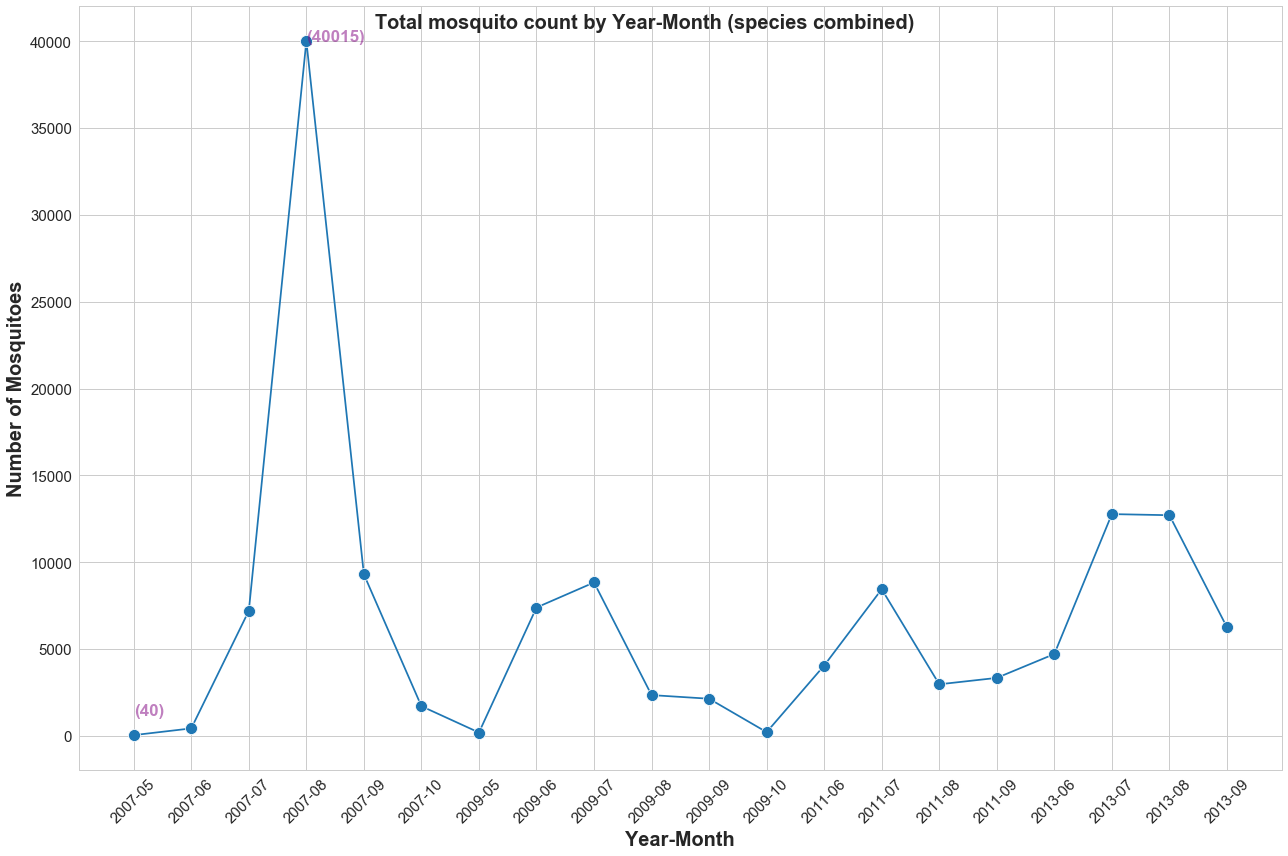

In [140]:
# plotting total number of mosquitos per month

temp_df = g_train.groupby(["YearMonth"]).sum()

plt.figure(figsize=(18,12))

sns.lineplot(x = temp_df.index,y = temp_df['NumMosquitos'], marker='o', markersize=12 )

plt.xlabel('Year-Month', fontweight='bold', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=45)

# to annotate the very first value
first_yearmonth = temp_df.sort_values(by="YearMonth", ascending=True).index[0]
first_val = temp_df.sort_values(by="YearMonth", ascending=True)["NumMosquitos"][0]
plt.text(x = first_yearmonth, y=1200, s="(" + str(first_val) + ")", alpha=0.5, color='purple', fontsize = "17", fontweight="bold")

# to annotate the peak value
max_yearmonth = temp_df.sort_values(by="NumMosquitos", ascending=False).index[0]
max_val = temp_df.sort_values(by="NumMosquitos", ascending=False)["NumMosquitos"][0]
plt.text(x=max_yearmonth, y=max_val, s="(" + str(max_val) + ")", alpha=0.5, color='purple', fontsize = "17", fontweight="bold")

title = "Total mosquito count by Year-Month (species combined)"
plt.suptitle(title, fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tight_layout()

plt.savefig(title)

### Total mosquito count by Year-Month (by species)

In [141]:
color_dict = dict({
            'CULEX PIPIENS':'tomato',
            'CULEX PIPIENS/RESTUANS':'orange',
            'CULEX RESTUANS': 'gold',
            'CULEX SALINARIUS': 'wheat',
            'CULEX TERRITANS': 'teal',
            'CULEX TARSALIS' : 'forestgreen',
            'CULEX ERRATICUS': 'dodgerblue'
          })

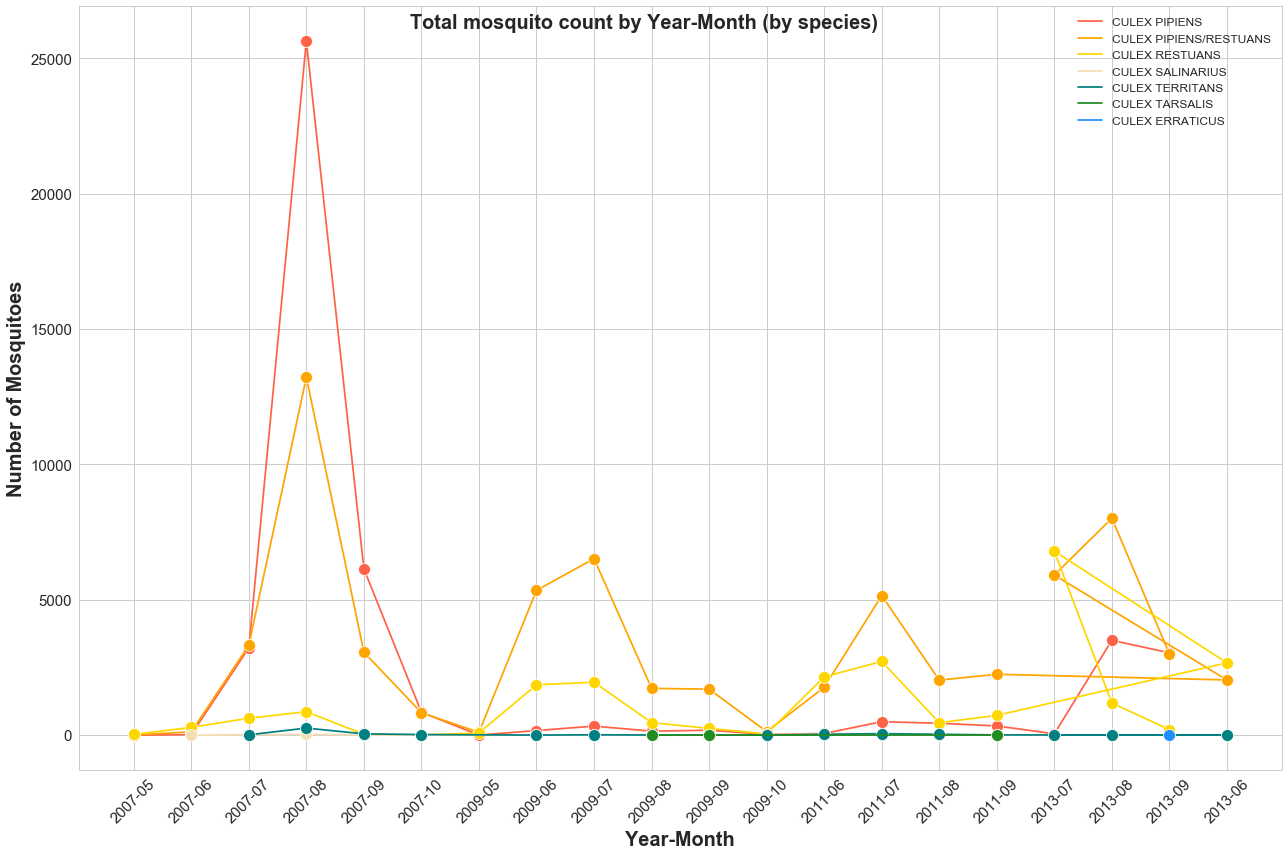

In [142]:
# plotting number of mosquitos per month, segregated by species

# creating a temporary df for our groupby view
temp_df = g_train.groupby(["YearMonth","Species"]).sum()

# since temp_df now is a multi-index df, we need to iterate through the index to pass `YearMonth` and `Species` to the plot  function
x_index = [keys for keys, values in temp_df.index]
hue_index = [values for keys, values in temp_df.index]

plt.figure(figsize=(18,12))

sns.lineplot(x = x_index,y = "NumMosquitos", data =temp_df.sort_index(level=0), marker='o', markersize=12, hue=hue_index, palette=color_dict)


plt.xlabel('Year-Month', fontweight='bold', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=45)

title = "Total mosquito count by Year-Month (by species)"
plt.suptitle(title, fontweight='bold', fontsize='20', horizontalalignment='center')

plt.legend(fontsize='large', title_fontsize='20')


plt.tight_layout()

plt.savefig(title)

### Total mosquito count by Year (by species)

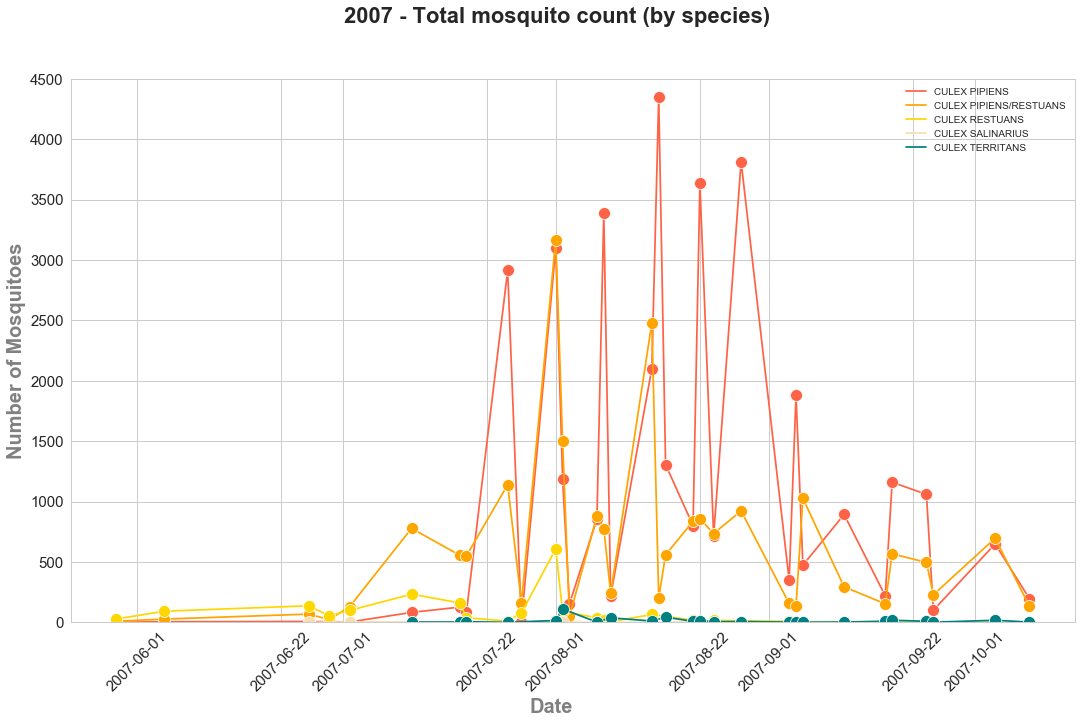

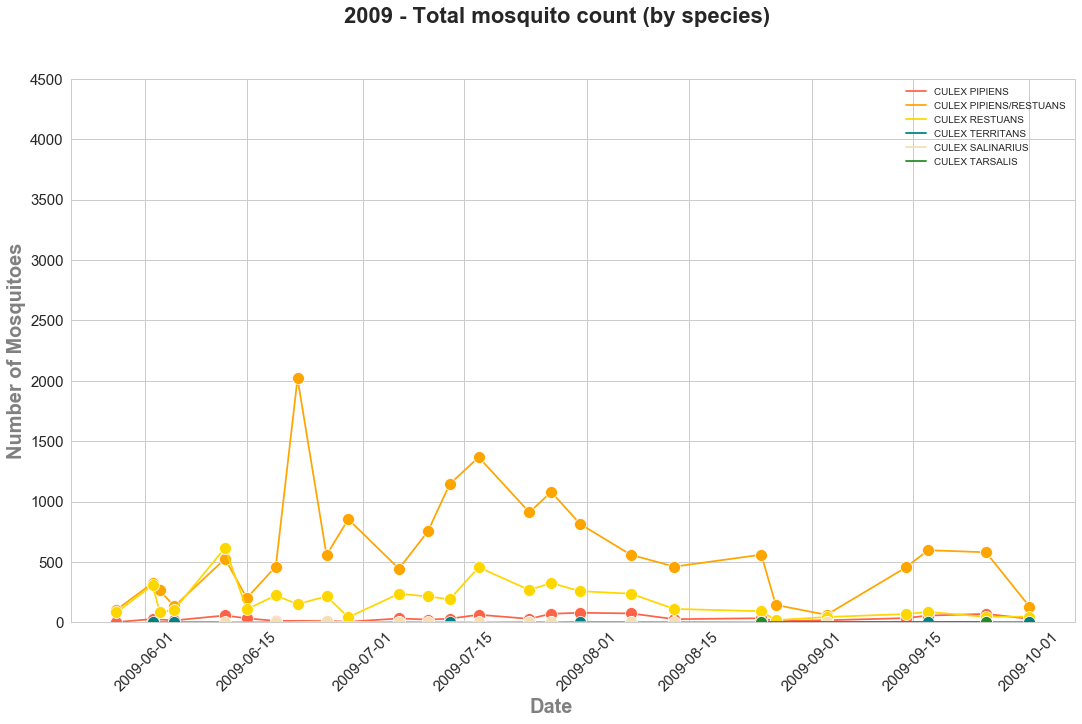

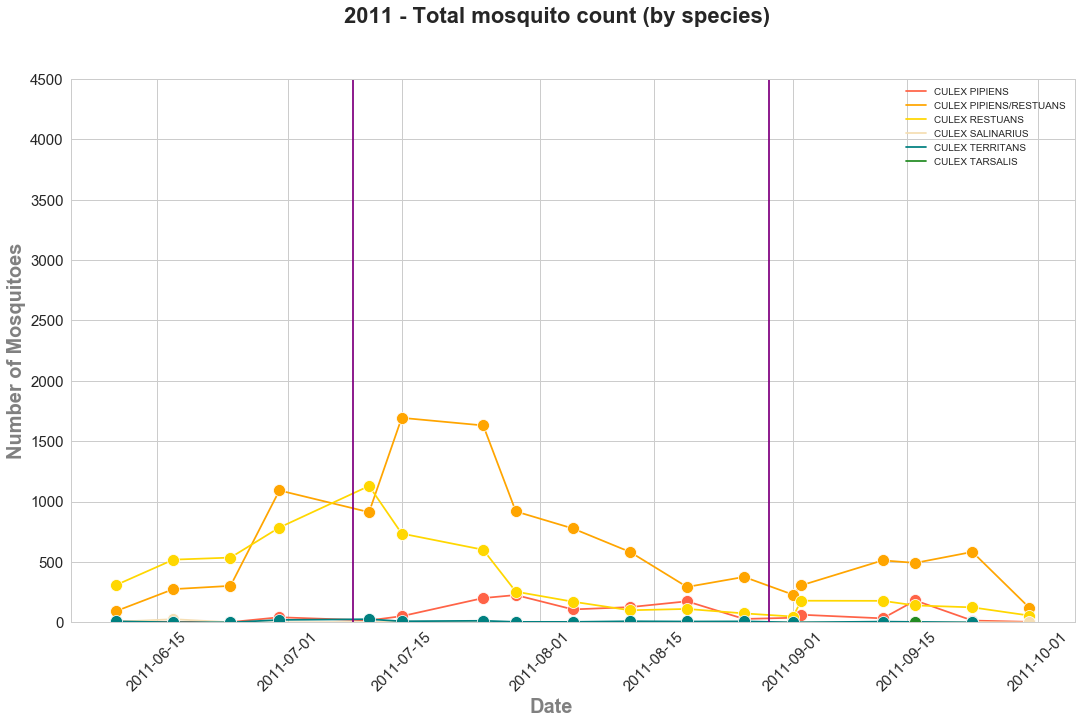

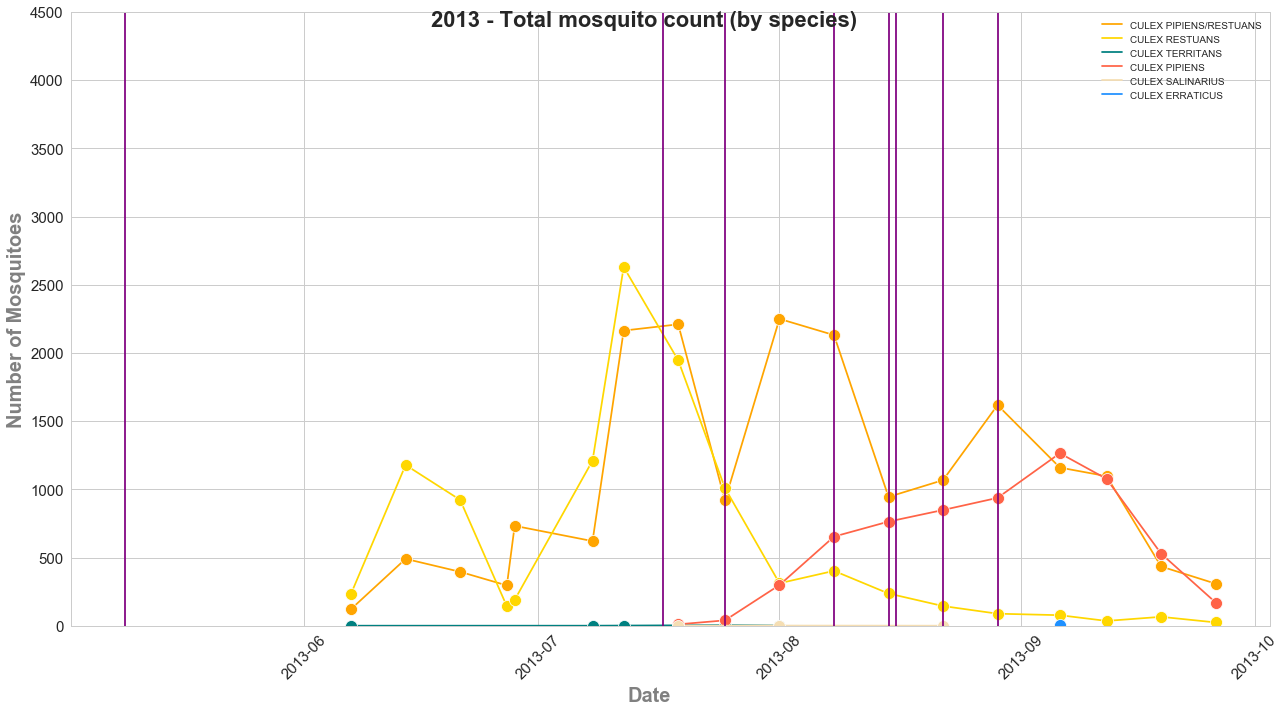

In [143]:
# to show total number of mosquitos per date, segregated by species, with spray dates indicated in purple

for yr in [y for y in g_train['Date'].apply(lambda x: x.year).unique()]:

    # creating a temporary df to show only records for a particular year, grouped by date and species
    temp_df = g_train[g_train["Year"] == yr].groupby(["Date", "Species"]).sum()

    # since temp_df now is a multi-index df, we need to iterate through the index 
    # to pass `Date` and `Species` to the plot  function
    date_index = [keys for keys, values in temp_df.index]
    hue_index = [values for keys, values in temp_df.index]
    
    plt.figure(figsize=(18,10))

    sns.lineplot(x = date_index, y = "NumMosquitos", data =temp_df, marker='o', markersize=12, hue=hue_index, palette=color_dict)

    plt.xlabel('Date', fontweight='bold', fontsize='20', horizontalalignment="right", color="gray")
    plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center', color="gray")
    plt.ylim(0, 4500)

    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks(rotation=45)
    
    for sp_date in unique_spray_dates:
        if yr == sp_date.year:
            plt.axvline(sp_date, label="spray", color='purple')
#             plt.text(x=sp_date, y=1200, s=f'{sp_date}', alpha=0.7, color='purple')
        else:
            pass
    
    title = f"{yr} - Total mosquito count (by species)"
    plt.suptitle(title, fontweight='bold', fontsize='22', horizontalalignment='center')

plt.tight_layout()

### Effect of spraying by date and distance

In [144]:
# this function takes in number of days and spray radius
# then charts total number of mosquitoes (per species) 

# `ndays` refers to the number of days to look up. 
# this only works if nearest_spray() has been called to populate relevant data
# `dist_m` refer to the maximum distance (in metres) that the nearest spray site can be from a trap location 
# for the trap to be considered sprayed
# e.g. if `dist_m` is 100, then this function will only consider traps sprayed
# if the nearest site is no more than 100m away


def spray_effect(ndays, dist_m):
    
    col_name = "n" + str(ndays) + "_spray_dist_m"
    
    if col_name in g_train.columns:
    
        days_df = g_train[g_train[col_name].notnull()]
        
        dist_df = days_df[days_df[col_name] <= dist_m]
        
        if dist_df.shape[0] == 0:
            
            return f"Error: No records returned for `ndays` {ndays} and distance {dist_m}m."
        
        else: 
        
            for yr in [y for y in g_train["Year"].unique()]:
                
                if (yr == 2011) or (yr == 2013):
                    
                    # creating a temporary df to show only records for a particular year, grouped by date and species
                    temp_df = dist_df[dist_df["Year"] == yr].groupby(["Date", "Species"]).sum()

                    # since temp_df now is a multi-index df, we need to iterate through the index 
                    # to pass `Date` and `Species` to the plot  function
                    date_index = [keys for keys, values in temp_df.index]
                    hue_index = [values for keys, values in temp_df.index]

                    plt.figure(figsize=(18,12))

                    sns.lineplot(x = date_index, y = "NumMosquitos", data =temp_df, marker='o', markersize=12, hue=hue_index, palette=color_dict)


                    plt.xlabel('Date', fontweight='bold', fontsize='20', horizontalalignment="right", color="gray")
                    plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center', color="gray")
    #                 plt.ylim(0, 4500)

                    plt.tick_params(axis='both', which='major', labelsize=15)
                    plt.xticks(rotation=45)


                    for sp_date in unique_spray_dates:
                        if yr == sp_date.year:
                            plt.axvline(sp_date, label="spray", color='purple')
                #             plt.text(x=sp_date, y=1200, s=f'{sp_date}', alpha=0.7, color='purple')
                
        
                        else:
                            pass


                    chart_title = f"{yr} - Total mosquito count (by species)\nrange = {ndays} days, {dist_m}m"
                    plt.suptitle(chart_title, fontweight='bold', fontsize='22', horizontalalignment='center')


                    plt.tight_layout()

                    image_title = f"n{ndays}_{dist_m}m - {yr} - Total moz (by species)"
                    plt.savefig(image_title)
                    
                
                    display(temp_df)
                    
                else:
                    pass

                
    else:
        
        return f"Error: Data for `ndays` = {ndays} not in table"

In [145]:
spray_effect(14, 500)

'Error: Data for `ndays` = 14 not in table'

In [146]:
spray_effect(7, 500)

'Error: No records returned for `ndays` 7 and distance 500m.'

In [148]:
spray_effect(3, 500)

'Error: No records returned for `ndays` 3 and distance 500m.'

In [149]:
spray_effect(3, 100)

'Error: No records returned for `ndays` 3 and distance 100m.'

### Conclusion: Relationship between train and spray data

So far we've tried looking at 3-day, 7-day and 14-day ranges with a very generous trap-to-spray distance of 500m. But mosquito count seems to be very erratic. After spraying, sometimes mosquito numbers goes up, and sometimes mosquito numbers go down. This lack of trend suggests that spraying may not have a meaningful impact on mosquito count. 

From research, we know that it takes 10-14 days (weather depending) for mosquito larvae to develop into an adult mosquito. However, since spraying is only useful for killing adult mosquitos, it's not necessary/useful to run this analysis with a date range beyond 14 days.

In addition, given that we only have 10 unique spray dates, there's really not enough data to meaningfully understand the effect of spraying on mosquito population - we cannot determine if this inconclusiveness is because spraying was not effective, or because of issues with the way spraying was carried out. 
From a modeling point of view, the incomplete data makes it difficult to train our model properly. 

Hence, our recommendation - based on the data sets provided - is to turn our attention from spraying to other factors.

## Weather

The weather records provided are between 2007 May and 2014 October. There is a second record everyday as there are 2 weather stations capturing the data each day. From the weather dataset, we are going to focus on variables translating to the optimal condition in the environment for reproduction and they are mainly separated into 2 sections; their habitats and temperature.

Habitat:

Culex mosquitoes breed in various types of stagnant water. Preferred oviposition habitats such as rainwater barrels, catch basins, storm drains, and septic tanks are rich in organic material. Eggs are laid in raft-shaped batches on the water surface.

While Culex will lay their eggs in a variety of standing waters, these habitats can typically be categorized into four ecotypes:

- Sewage Systems
- Container Sources
- Drainage Systems
- Open Habitats

https://www.valentbiosciences.com/publichealth/pests/mosquitoes/mosquitoes-culex/

Temperature:

According to a study conducted on the effects of temperature on the growth and development of Culex pipiens Complex Mosquitoes, it was discovered that varying temperatures were found to have effects on egg embryonation, the lengths of the pupal and larval periods and the survival and longevity of the female mosquitoes.

- In lower temperatures, embryonation took longer among the 20 degree Celsius (68 degree Fahrenheit) and 24 degree Celsius (75.2 degree Fahrenheit) the larval and pupal stages were longer and the female mosquitoes lived longer.
- In higher temperatures, 28 degree Celsius (84.4 degree Fahrenheit), embryonation was faster, the larval and pupal stages were shorter and the females did not live for as long as they did at 20 degree Celsius and 24 degree Celsius.

https://pdfs.semanticscholar.org/1e02/57f23ef925e437a5995c1720b3a2ab518cac.pdf

As such, at first glance, it it likely that the temperature columns "Tmax", "Tmin" and "Tavg" and "PrecipTotal" which indicate the amount of rain will provide the most information on the target.

In [70]:
# date range
weather = pd.read_csv('../assets/weather.csv', parse_dates=['Date'])
print(weather['Date'].max())
print(weather['Date'].min())

weather.head()

2014-10-31 00:00:00
2007-05-01 00:00:00


Station       Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1 2007-05-01    83    50   67     14        51      56    0    2   
1        2 2007-05-01    84    52   68      M        51      57    0    3   
2        1 2007-05-02    59    42   51     -3        42      47   14    0   
3        2 2007-05-02    60    43   52      M        42      47   13    0   
4        1 2007-05-03    66    46   56      2        40      48    9    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall PrecipTotal StnPressure  \
0    0448   1849             0      M      0.0        0.00       29.10   
1       -      -             M      M        M        0.00       29.18   
2    0447   1850      BR     0      M      0.0        0.00       29.38   
3       -      -   BR HZ     M      M        M        0.00       29.44   
4    0446   1851             0      M      0.0        0.00       29.39   

  SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6  
2    30.09         13.0          4     13.4  
3    30.08         13.3          2     13.4  
4    30.12         11.7          7     11.9

Traditional techniques will not be able to identify null values as they are being translated into 'M' (according to the data dictionary).

In [71]:
# no nulls but nulls are represented by values like M and -
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(15)
memory usage: 506.1+ KB


### Add dates

Based on the "Date" column, we will create new columns indicating the "year", "month" and the "weekofyear" columns to streamline our EDA. It is important as the data represented only a certain time period within each year;

- year -> 2007 - 2014
- month -> may - oct (corresponding to when traps are deployed)
- weekofyear -> 17 - 44

In [72]:
weather['Year'] = weather['Date'].apply(lambda x:x.year)
weather['Month'] = weather['Date'].apply(lambda x:x.month)
weather['WeekofYear'] = weather['Date'].apply(lambda x:x.weekofyear)

# view summary of unique values
print(weather.Year.value_counts().sort_index())
print(weather.Month.value_counts())
print(weather.WeekofYear.value_counts().sort_index())

2007    368
2008    368
2009    368
2010    368
2011    368
2012    368
2013    368
2014    368
Name: Year, dtype: int64
7     496
5     496
10    496
8     496
9     480
6     480
Name: Month, dtype: int64
17      6
18     84
19    112
20    112
21    112
22    112
23    112
24    112
25    112
26    112
27    112
28    112
29    112
30    112
31    112
32    112
33    112
34    112
35    112
36    112
37    112
38    112
39    112
40    112
41    112
42    112
43    112
44     54
Name: WeekofYear, dtype: int64


### Fill missing values

In [73]:
# replace trace and missing precip with 0s
weather.PrecipTotal.replace(['  T','M'],0,inplace=True)
weather.PrecipTotal = weather.PrecipTotal.astype(float)

# check number of rows with missing avg temp
print(weather.Tavg.value_counts()['M'])

# imputing Tavg manually (increases accuracy)
weather.Tavg = (weather.Tmax + weather.Tmin)/2
weather.Tavg = weather.Tavg.astype(float)


11


In [74]:
weather[weather.StnPressure=='M']

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
87          2 2007-06-13    86    68  77.0      M        53      62    0   12   
848         1 2009-06-26    86    69  77.5      7        60       M    0   13   
2410        1 2013-08-10    81    64  72.5      0        57       M    0    8   
2411        2 2013-08-10    81    68  74.5      M        55      63    0   10   

     Sunrise Sunset CodeSum Depth Water1 SnowFall  PrecipTotal StnPressure  \
87         -      -             M      M        M          0.0           M   
848     0418   1931             0      M      0.0          0.0           M   
2410    0454   1900             0      M      0.0          0.0           M   
2411       -      -             M      M        M          0.0           M   

     SeaLevel  ResultSpeed  ResultDir AvgSpeed  Year  Month  WeekofYear  
87          M          7.0          5        M  2007      6          24  
848     29.85          6.4          4      8.2  2009      6          26  
2410    30.08          5.3          5      6.5  2013      8          32  
2411    30.07          6.0          6      7.4  2013      8          32

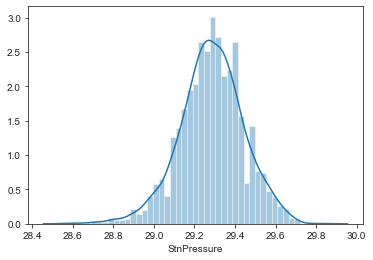

In [75]:
sns.distplot(weather.loc[(weather.StnPressure != 'M'), 'StnPressure'].map(lambda x : float(x)))

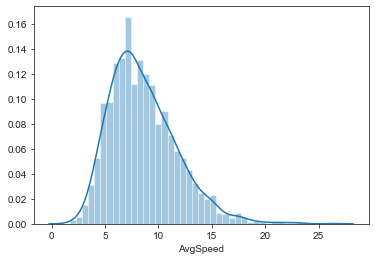

In [76]:
sns.distplot(weather.loc[(weather.AvgSpeed != 'M'), 'AvgSpeed'].map(lambda x : float(x)))

In [77]:
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')


weather.StnPressure = weather.StnPressure.map(lambda x : np.nan if x == 'M' else x)
weather.AvgSpeed = weather.AvgSpeed.map(lambda x : np.nan if x == 'M' else x)

weather.StnPressure = imp_mean.fit_transform(weather.StnPressure.values.reshape(-1, 1))
weather.AvgSpeed = imp_mean.fit_transform(weather.AvgSpeed.values.reshape(-1, 1))


### Differences between Weather Station 1 and Weather Station 2

Since there are 2 weather stations capturing the weather statistics each day, we will explore the differences in the data captured for each station, mainly focusing on the columns "Tavg" and "PrecipTotal" which are likely to provide more information on our target.

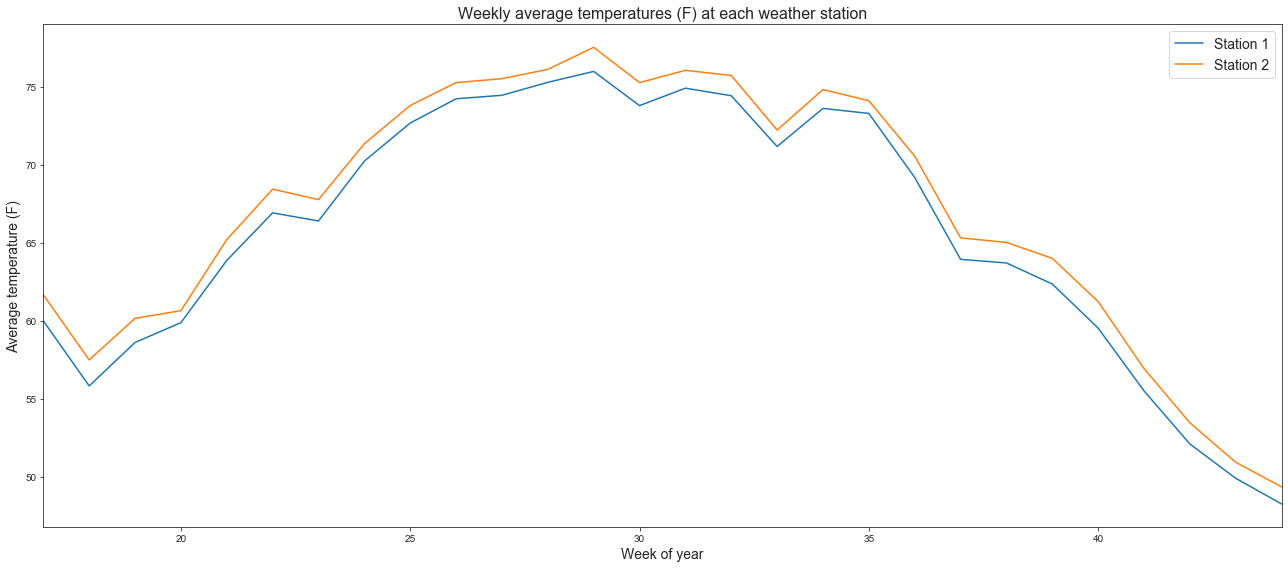

In [78]:
# plot weekly temperature by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'WeekofYear',y = 'Tavg', data = weather[weather.Station==1], ci = None, label = "Station 1")
sns.lineplot(x = 'WeekofYear',y = 'Tavg', data = weather[weather.Station==2], ci = None, label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly average temperatures (F) at each weather station', fontsize=16)
plt.xlabel('Week of year',fontsize=14)
plt.ylabel('Average temperature (F)',fontsize=14)
plt.xlim(weather.WeekofYear.min(), weather.WeekofYear.max())
plt.tight_layout()

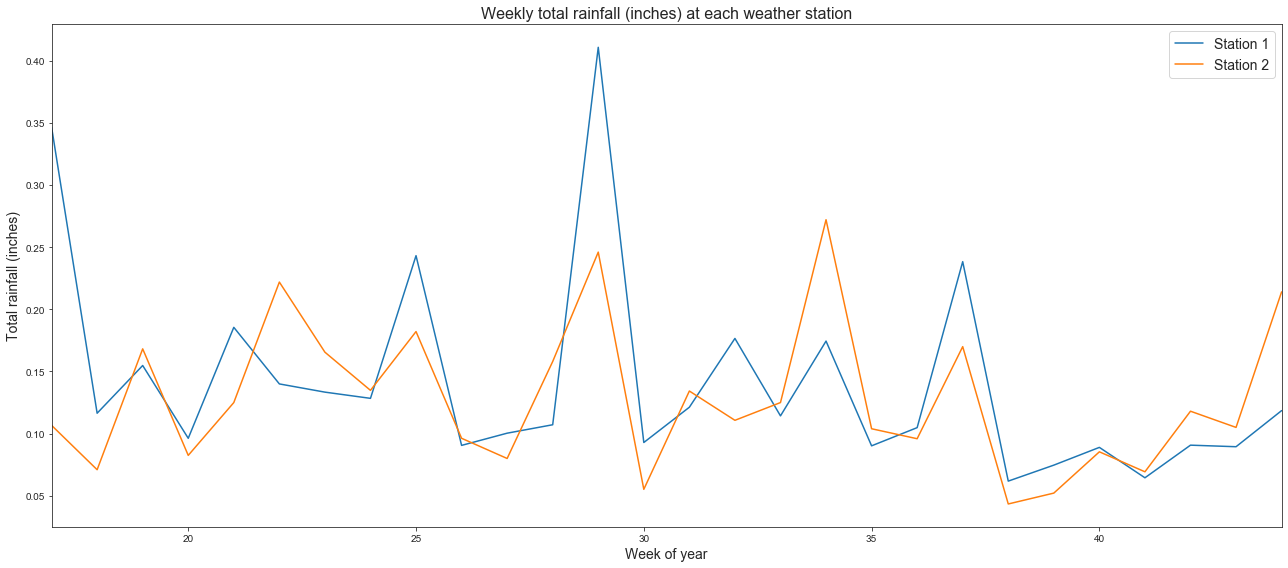

In [79]:
# plot weekly rainfall by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'WeekofYear',y = 'PrecipTotal',data = weather[weather.Station==1],ci = None,label = "Station 1")
sns.lineplot(x = 'WeekofYear',y = 'PrecipTotal',data = weather[weather.Station==2],ci = None,label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly total rainfall (inches) at each weather station', fontsize=16)
plt.xlabel('Week of year',fontsize=14)
plt.ylabel('Total rainfall (inches)',fontsize=14)
plt.xlim(weather.WeekofYear.min(), weather.WeekofYear.max())
plt.tight_layout()

From the graphs above, there are in fact discrepancies between the data captured which may likely be due to the difference in distance between the 2 stations. However, the discrepancies between the 2 weather stations seem to be insignificant visually especially from the graph showing the average temperature.

### Engineer some new features

**1. `Tavg` x (`PrecipTotal` + 1)**<br>
Temperature may have synergistic effects on the mosquito life cycle with precipitation. 1 is added to `PrecipTotal` to keep the `Tavg` value unchanged when `PrecipTotal` = 0 (i.e. no rain).

**2. Relative humidity**

**3. Temperature range**

**4. Delayed weather measurements**<br>
The average life cycle (eggs - adult) of a <i>Culex</i> mosquito is 14 days (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5654580/). Therefore, new columns will be created with the various weather columns being offset by 14 days.

In [80]:
weather['Date_Station'] = weather['Date'].astype(str) + '_' + weather['Station'].astype(str)

In [81]:
weather_sun = weather.loc[weather['Station'] == 1].copy()

weather_sun['Sunset'].unique()

array(['1849', '1850', '1851', '1852', '1853', '1855', '1856', '1857',
       '1858', '1859', '1860', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
       '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921',
       '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929',
       '1930', '1931', '1900', '1854', '1848', '1846', '1845', '1843',
       '1842', '1840', '1839', '1837', '1835', '1834', '1832', '1831',
       '1829', '1827', '1826', '1824', '1822', '1821', '1819', '1817',
       '1815', '1814', '1812', '1810', '1809', '1807', '1805', '1803',
       '1760', '1758', '1756', '1755', '1753', '1751', '1749', '1748',
       '1746', '1744', '1742', '1741', '1739', '1737', '1735', '1734',
       '1732', '1730', '1729', '1727', '1725', '1724', '1722', '1720',
       '1719', '1717', '1715', '1714', '1712', '1711', '1709', '1707',
       '1706', '1704', '1703', '1701', '1660', '1658', '1657', '1656',
      

In [82]:
# Cleaning up wrong formatted of Sunset time

weather_sun['Sunset'] = weather_sun['Sunset'].map(lambda x : (str(int(x[0:2]) + 1) + '00') if x[2:4] == '60' else x)


weather_sun['Sunrise_Time'] = weather_sun['Sunrise'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_sun['Sunset_Time'] = weather_sun['Sunset'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_sun['Daylight_Minutes'] = (weather_sun['Sunset_Time'] - weather_sun['Sunrise_Time']).map(lambda x : x.seconds / 60)


# Actually doesn't share that much correlation with average temperature, so may be we will want to add this in

weather_sun[['Daylight_Minutes', 'Tavg']].corr()


Daylight_Minutes      Tavg
Daylight_Minutes          1.000000  0.553301
Tavg                      0.553301  1.000000

In [83]:
weather = weather.merge(weather_sun[['Date', 'Daylight_Minutes']], on = 'Date')

In [84]:
# humidity
Tavg_C = ((weather['Tavg'] - 32) * 5 / 9)
DewPoint_C = ((weather['DewPoint'] - 32) * 5 / 9)
VapPress_Sat = np.exp((17.625 * Tavg_C) / (Tavg_C + 243.04))
VapPress_Act = np.exp((17.625 * DewPoint_C) / (DewPoint_C + 243.04))
R_Humidity = (VapPress_Act / VapPress_Sat) * 100

weather['R_Humid'] = R_Humidity

# temperature range
weather['Trange'] = weather['Tmax'] - weather['Tmin']

In [85]:
weather.head()

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1 2007-05-01    83    50  66.5     14        51      56    0    2   
1        2 2007-05-01    84    52  68.0      M        51      57    0    3   
2        1 2007-05-02    59    42  50.5     -3        42      47   14    0   
3        2 2007-05-02    60    43  51.5      M        42      47   13    0   
4        1 2007-05-03    66    46  56.0      2        40      48    9    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall  PrecipTotal  StnPressure  \
0    0448   1849             0      M      0.0          0.0        29.10   
1       -      -             M      M        M          0.0        29.18   
2    0447   1850      BR     0      M      0.0          0.0        29.38   
3       -      -   BR HZ     M      M        M          0.0        29.44   
4    0446   1851             0      M      0.0          0.0        29.39   

  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  Year  Month  WeekofYear  \
0    29.82          1.7         27       9.2  2007      5          18   
1    29.82          2.7         25       9.6  2007      5          18   
2    30.09         13.0          4      13.4  2007      5          18   
3    30.08         13.3          2      13.4  2007      5          18   
4    30.12         11.7          7      11.9  2007      5          18   

   Date_Station  Daylight_Minutes    R_Humid  Trange  
0  2007-05-01_1             841.0  57.422798      33  
1  2007-05-01_2             841.0  54.526426      32  
2  2007-05-02_1             843.0  72.526813      17  
3  2007-05-02_2             843.0  69.892062      17  
4  2007-05-03_1             845.0  54.874919      20

### Drop extra columns

In [86]:
# drop codesum as most of it is rain, which is captured in precip
weather.CodeSum.value_counts()

                        1609
RA                       296
RA BR                    238
BR                       110
TSRA RA BR                92
BR HZ                     81
RA DZ BR                  65
TSRA RA                   43
HZ                        39
RA BR HZ                  38
TSRA                      34
RA DZ                     22
TSRA BR                   21
TS TSRA RA BR             19
RA HZ                     16
TS RA                     13
TSRA RA BR HZ             12
DZ BR                     10
TS                        10
TS TSRA BR                10
DZ BR HZ                   9
DZ                         8
TS RA BR                   8
TSRA BR HZ                 8
RA DZ BR HZ                7
TS TSRA RA                 7
TS TSRA                    7
TS TSRA BR HZ              7
TSRA RA BR VCTS            4
FG+ BR                     4
                        ... 
TSRA RA BR HZ VCTS         1
BR HZ VCFG                 1
RA FG+ MIFG BR             1
TSRA DZ FG+ FG

In [87]:
# # drop unnecesary columns (including those that station 2 doesn't record)
# col_to_drop = ['Tmax','Tmin','ResultSpeed','ResultDir']
# weather.drop(col_to_drop, axis = 1,inplace=True)

### Univariate EDA

In [88]:
# combine data from the 2 weather stations
weather_combined = weather.groupby('Date').mean()
weather_combined.drop(['Station', 'Year','Month','WeekofYear'],axis=1,inplace=True)
weather_combined.reset_index(inplace=True)

In [89]:
# adding year/month/week columns back as they were previously affected by the groupby function and removed
weather_combined['year'] = weather_combined['Date'].apply(lambda x:x.year)
weather_combined['month'] = weather_combined['Date'].apply(lambda x:x.month)
weather_combined['weekofyear'] = weather_combined['Date'].apply(lambda x:x.weekofyear)

In [90]:
weather_combined.head()

Date  Tmax  Tmin   Tavg  DewPoint  PrecipTotal  StnPressure  \
0 2007-05-01  83.5  51.0  67.25      51.0          0.0       29.140   
1 2007-05-02  59.5  42.5  51.00      42.0          0.0       29.410   
2 2007-05-03  66.5  47.0  56.75      40.0          0.0       29.425   
3 2007-05-04  72.0  50.0  61.00      41.5          0.0       29.335   
4 2007-05-05  66.0  53.5  59.75      38.5          0.0       29.430   

   ResultSpeed  ResultDir  AvgSpeed  Daylight_Minutes    R_Humid  Trange  \
0         2.20       26.0      9.40             841.0  55.974612    32.5   
1        13.15        3.0     13.40             843.0  71.209437    17.0   
2        12.30        6.5     12.55             845.0  53.429105    19.5   
3        10.25        7.5     10.60             848.0  48.932050    22.0   
4        11.45        7.0     11.75             850.0  45.237980    12.5   

   year  month  weekofyear  
0  2007      5          18  
1  2007      5          18  
2  2007      5          18  
3  2007      5          18  
4  2007      5          18

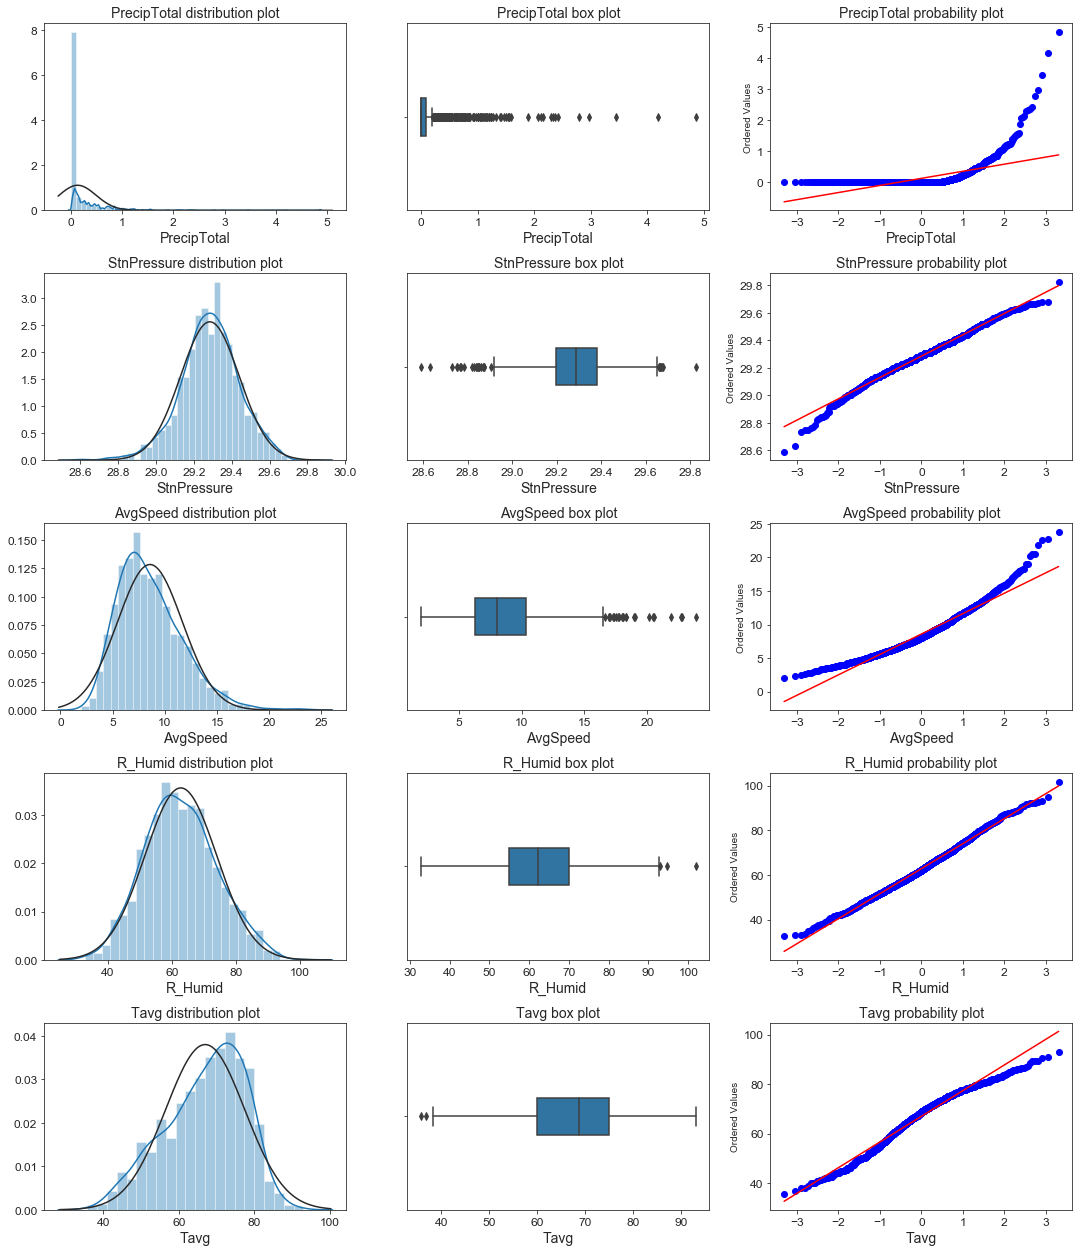

In [91]:
dist_plots(weather_combined,['Tavg', 'PrecipTotal', 'StnPressure', 'AvgSpeed', 'R_Humid',])

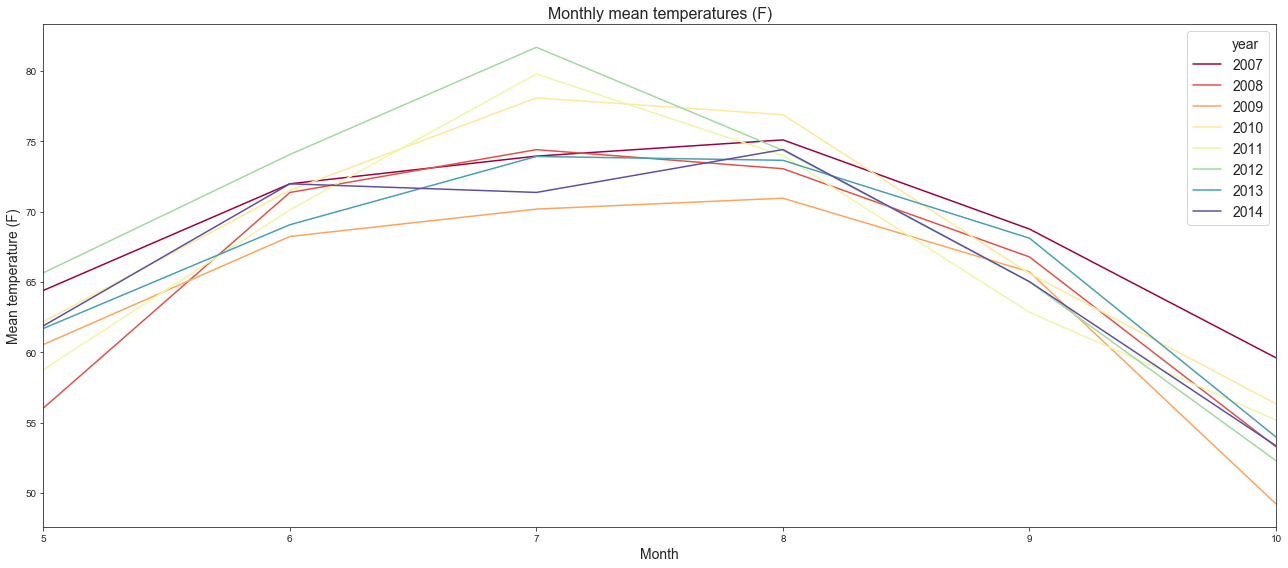

In [92]:
# plot temperature by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'Tavg', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean temperatures (F)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean temperature (F)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

Generally, the temperature cycle climbs from May to August and peak in July (with the exception of 2007 and 2014 where the peak is in August) before starting to decrease from August.

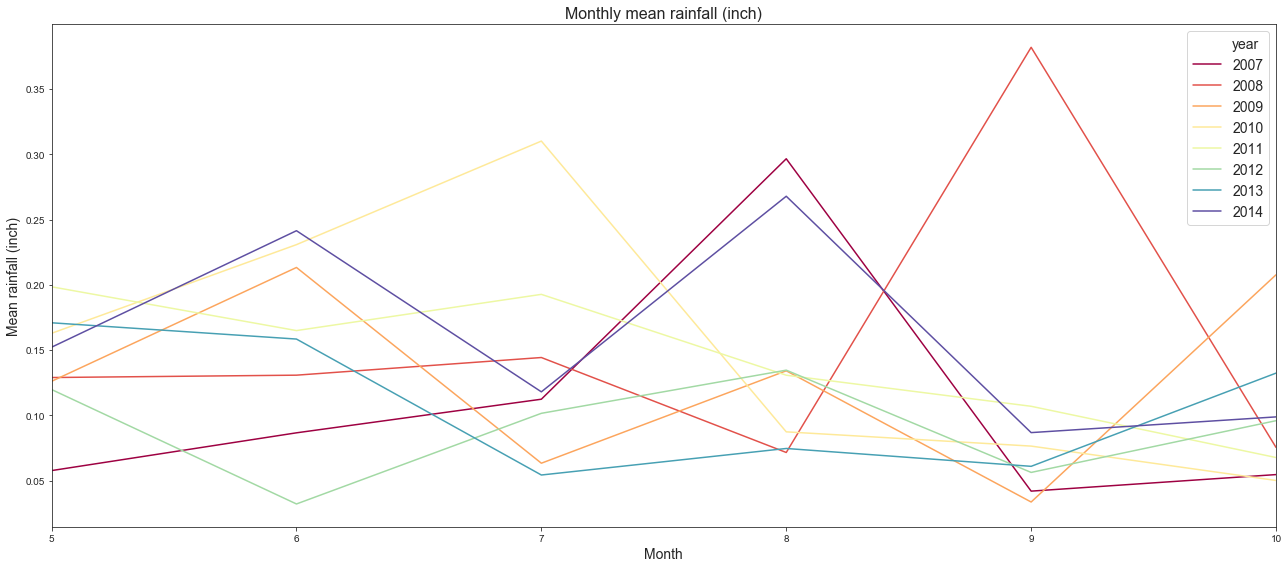

In [93]:
# plot rainfall by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'PrecipTotal', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean rainfall (inch)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean rainfall (inch)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

There is no distinct pattern in the average amount of rainfall as it varies from year to year. However, it does look have an exceptionally high amount of average rainfall in September 2008.

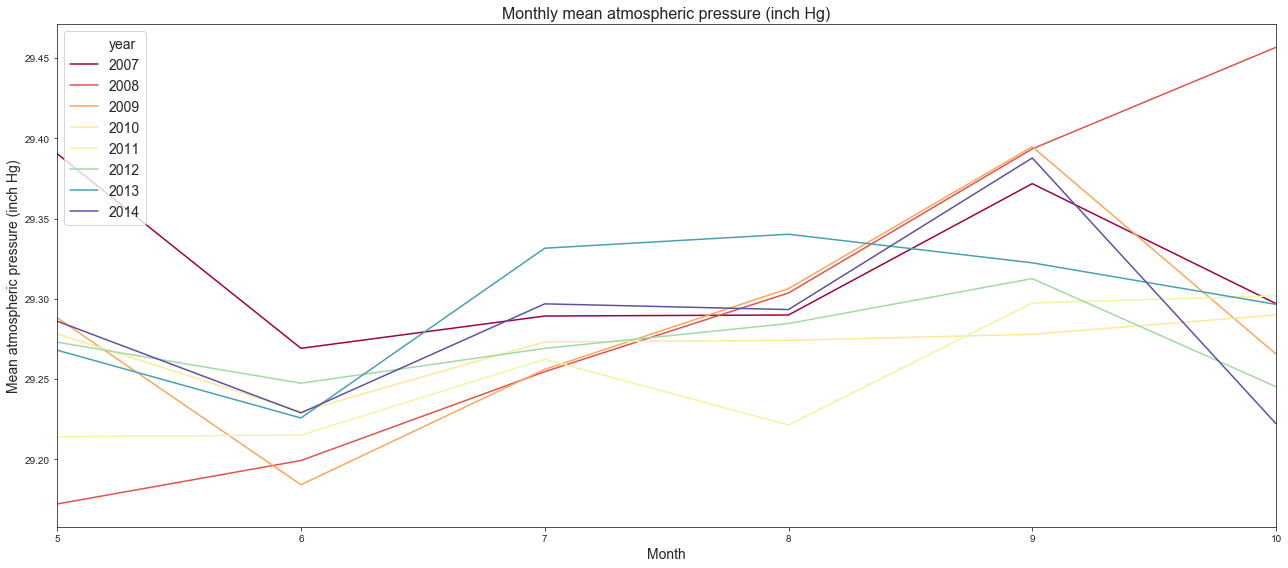

In [94]:
# plot atmospheric pressure by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'StnPressure', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(loc = 'upper left', fontsize = 14)
plt.title('Monthly mean atmospheric pressure (inch Hg)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean atmospheric pressure (inch Hg)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

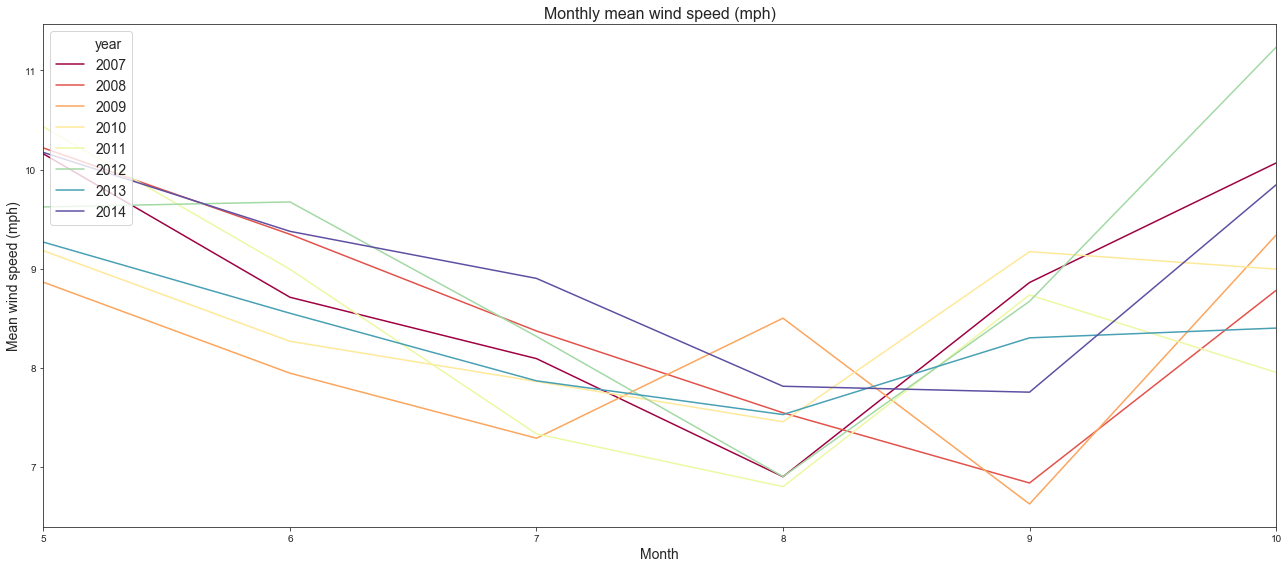

In [95]:
# plot wind speed by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'AvgSpeed', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(loc = 'upper left', fontsize = 14)
plt.title('Monthly mean wind speed (mph)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean wind speed (mph)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

### Bivariate EDA

#### Combine weather + traps

In [96]:
trap.head()

Date                                           Address  \
0  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2  2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3  2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4  2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8   

   Year  Month  WeekofYear YearMonth  NumMosquitos  WnvPresent  \
0  2007      5          22   2007-05             1           0   
1  2007      5          22   2007-05             2           0   
2  2007      5          22   2007-05             1           0   
3  2007      5          22   2007-05             1           0   
4  2007      5          22   2007-05             1           0   

                     Coord  Cluster                      geometry  Day  Week  \
0  (41.867108, -87.654224)        4  POINT (-87.654224 41.867108)   29    22   
1  (41.867108, -87.654224)        4  POINT (-87.654224 41.867108)   29    22   
2   (41.862292, -87.64886)        4   POINT (-87.64886 41.862292)   29    22   
3  (41.896282, -87.655232)        5  POINT (-87.655232 41.896282)   29    22   
4  (41.907645, -87.760886)        7  POINT (-87.760886 41.907645)   29    22   

  n3_intersect_dates n3_spray_sets n3_spray_geom n3_spray_coord  \
0               None          None          None           None   
1               None          None          None           None   
2               None          None          None           None   
3               None          None          None           None   
4               None          None          None           None   

  n3_spray_dist_deg n3_spray_dist_m  
0              None            None  
1              None            None  
2              None            None  
3              None            None  
4              None            None

In [97]:
station_points = MultiPoint([Point(41.995, -87.933), Point(41.786, -87.752)])
trap['Nearest_Station'] = trap['geometry'].map(lambda x : 1 if nearest_points(station_points, x)[0] == station_points[0] else 2)

trap['Date_Station'] = trap['Date'].astype(str) + '_' + trap['Nearest_Station'].astype(str)


In [98]:
weather.head()

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1 2007-05-01    83    50  66.5     14        51      56    0    2   
1        2 2007-05-01    84    52  68.0      M        51      57    0    3   
2        1 2007-05-02    59    42  50.5     -3        42      47   14    0   
3        2 2007-05-02    60    43  51.5      M        42      47   13    0   
4        1 2007-05-03    66    46  56.0      2        40      48    9    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall  PrecipTotal  StnPressure  \
0    0448   1849             0      M      0.0          0.0        29.10   
1       -      -             M      M        M          0.0        29.18   
2    0447   1850      BR     0      M      0.0          0.0        29.38   
3       -      -   BR HZ     M      M        M          0.0        29.44   
4    0446   1851             0      M      0.0          0.0        29.39   

  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  Year  Month  WeekofYear  \
0    29.82          1.7         27       9.2  2007      5          18   
1    29.82          2.7         25       9.6  2007      5          18   
2    30.09         13.0          4      13.4  2007      5          18   
3    30.08         13.3          2      13.4  2007      5          18   
4    30.12         11.7          7      11.9  2007      5          18   

   Date_Station  Daylight_Minutes    R_Humid  Trange  
0  2007-05-01_1             841.0  57.422798      33  
1  2007-05-01_2             841.0  54.526426      32  
2  2007-05-02_1             843.0  72.526813      17  
3  2007-05-02_2             843.0  69.892062      17  
4  2007-05-03_1             845.0  54.874919      20

In [99]:
#weather.drop(['Date', 'year','month','weekofyear'], axis=1, inplace=True)
combined = pd.merge(trap.drop(columns = 'Date'), weather.drop(columns = ['Date', 'Year','Month',\
                                                                         'WeekofYear']), how = 'left', \
                                                              left_on = 'Date_Station', \
                                                              right_on = 'Date_Station')
combined.head()

Address                 Species  \
0       1100 Roosevelt Road, Chicago, IL 60608, USA  CULEX PIPIENS/RESTUANS   
1       1100 Roosevelt Road, Chicago, IL 60608, USA          CULEX RESTUANS   
2  1100 South Peoria Street, Chicago, IL 60608, USA          CULEX RESTUANS   
3  1100 West Chicago Avenue, Chicago, IL 60642, USA          CULEX RESTUANS   
4    1500 North Long Avenue, Chicago, IL 60651, USA          CULEX RESTUANS   

   Block        Street  Trap          AddressNumberAndStreet   Latitude  \
0     11   W ROOSEVELT  T048  1100  W ROOSEVELT, Chicago, IL  41.867108   
1     11   W ROOSEVELT  T048  1100  W ROOSEVELT, Chicago, IL  41.867108   
2     11   S PEORIA ST  T091  1100  S PEORIA ST, Chicago, IL  41.862292   
3     11     W CHICAGO  T049    1100  W CHICAGO, Chicago, IL  41.896282   
4     15    N LONG AVE  T153   1500  N LONG AVE, Chicago, IL  41.907645   

   Longitude  AddressAccuracy  Year  Month  WeekofYear YearMonth  \
0 -87.654224                8  2007      5          22   2007-05   
1 -87.654224                8  2007      5          22   2007-05   
2 -87.648860                8  2007      5          22   2007-05   
3 -87.655232                8  2007      5          22   2007-05   
4 -87.760886                8  2007      5          22   2007-05   

   NumMosquitos  WnvPresent                    Coord  Cluster  \
0             1           0  (41.867108, -87.654224)        4   
1             2           0  (41.867108, -87.654224)        4   
2             1           0   (41.862292, -87.64886)        4   
3             1           0  (41.896282, -87.655232)        5   
4             1           0  (41.907645, -87.760886)        7   

                       geometry  Day  Week n3_intersect_dates n3_spray_sets  \
0  POINT (-87.654224 41.867108)   29    22               None          None   
1  POINT (-87.654224 41.867108)   29    22               None          None   
2   POINT (-87.64886 41.862292)   29    22               None          None   
3  POINT (-87.655232 41.896282)   29    22               None          None   
4  POINT (-87.760886 41.907645)   29    22               None          None   

  n3_spray_geom n3_spray_coord n3_spray_dist_deg n3_spray_dist_m  \
0          None           None              None            None   
1          None           None              None            None   
2          None           None              None            None   
3          None           None              None            None   
4          None           None              None            None   

   Nearest_Station  Date_Station  Station  Tmax  Tmin  Tavg Depart  DewPoint  \
0                2  2007-05-29_2        2    88    65  76.5      M        59   
1                2  2007-05-29_2        2    88    65  76.5      M        59   
2                2  2007-05-29_2        2    88    65  76.5      M        59   
3                2  2007-05-29_2        2    88    65  76.5      M        59   
4                2  2007-05-29_2        2    88    65  76.5      M        59   

  WetBulb Heat Cool Sunrise Sunset CodeSum Depth Water1 SnowFall  PrecipTotal  \
0      66    0   12       -      -   BR HZ     M      M        M          0.0   
1      66    0   12       -      -   BR HZ     M      M        M          0.0   
2      66    0   12       -      -   BR HZ     M      M        M          0.0   
3      66    0   12       -      -   BR HZ     M      M        M          0.0   
4      66    0   12       -      -   BR HZ     M      M        M          0.0   

   StnPressure SeaLevel  ResultSpeed  ResultDir  AvgSpeed  Daylight_Minutes  \
0        29.44    30.09          5.8         16       7.4             896.0   
1        29.44    30.09          5.8         16       7.4             896.0   
2        29.44    30.09          5.8         16       7.4             896.0   
3        29.44    30.09          5.8         16       7.4             896.0   
4        29.44    30.09          5.8         16       7.4             8

#### Pairplot

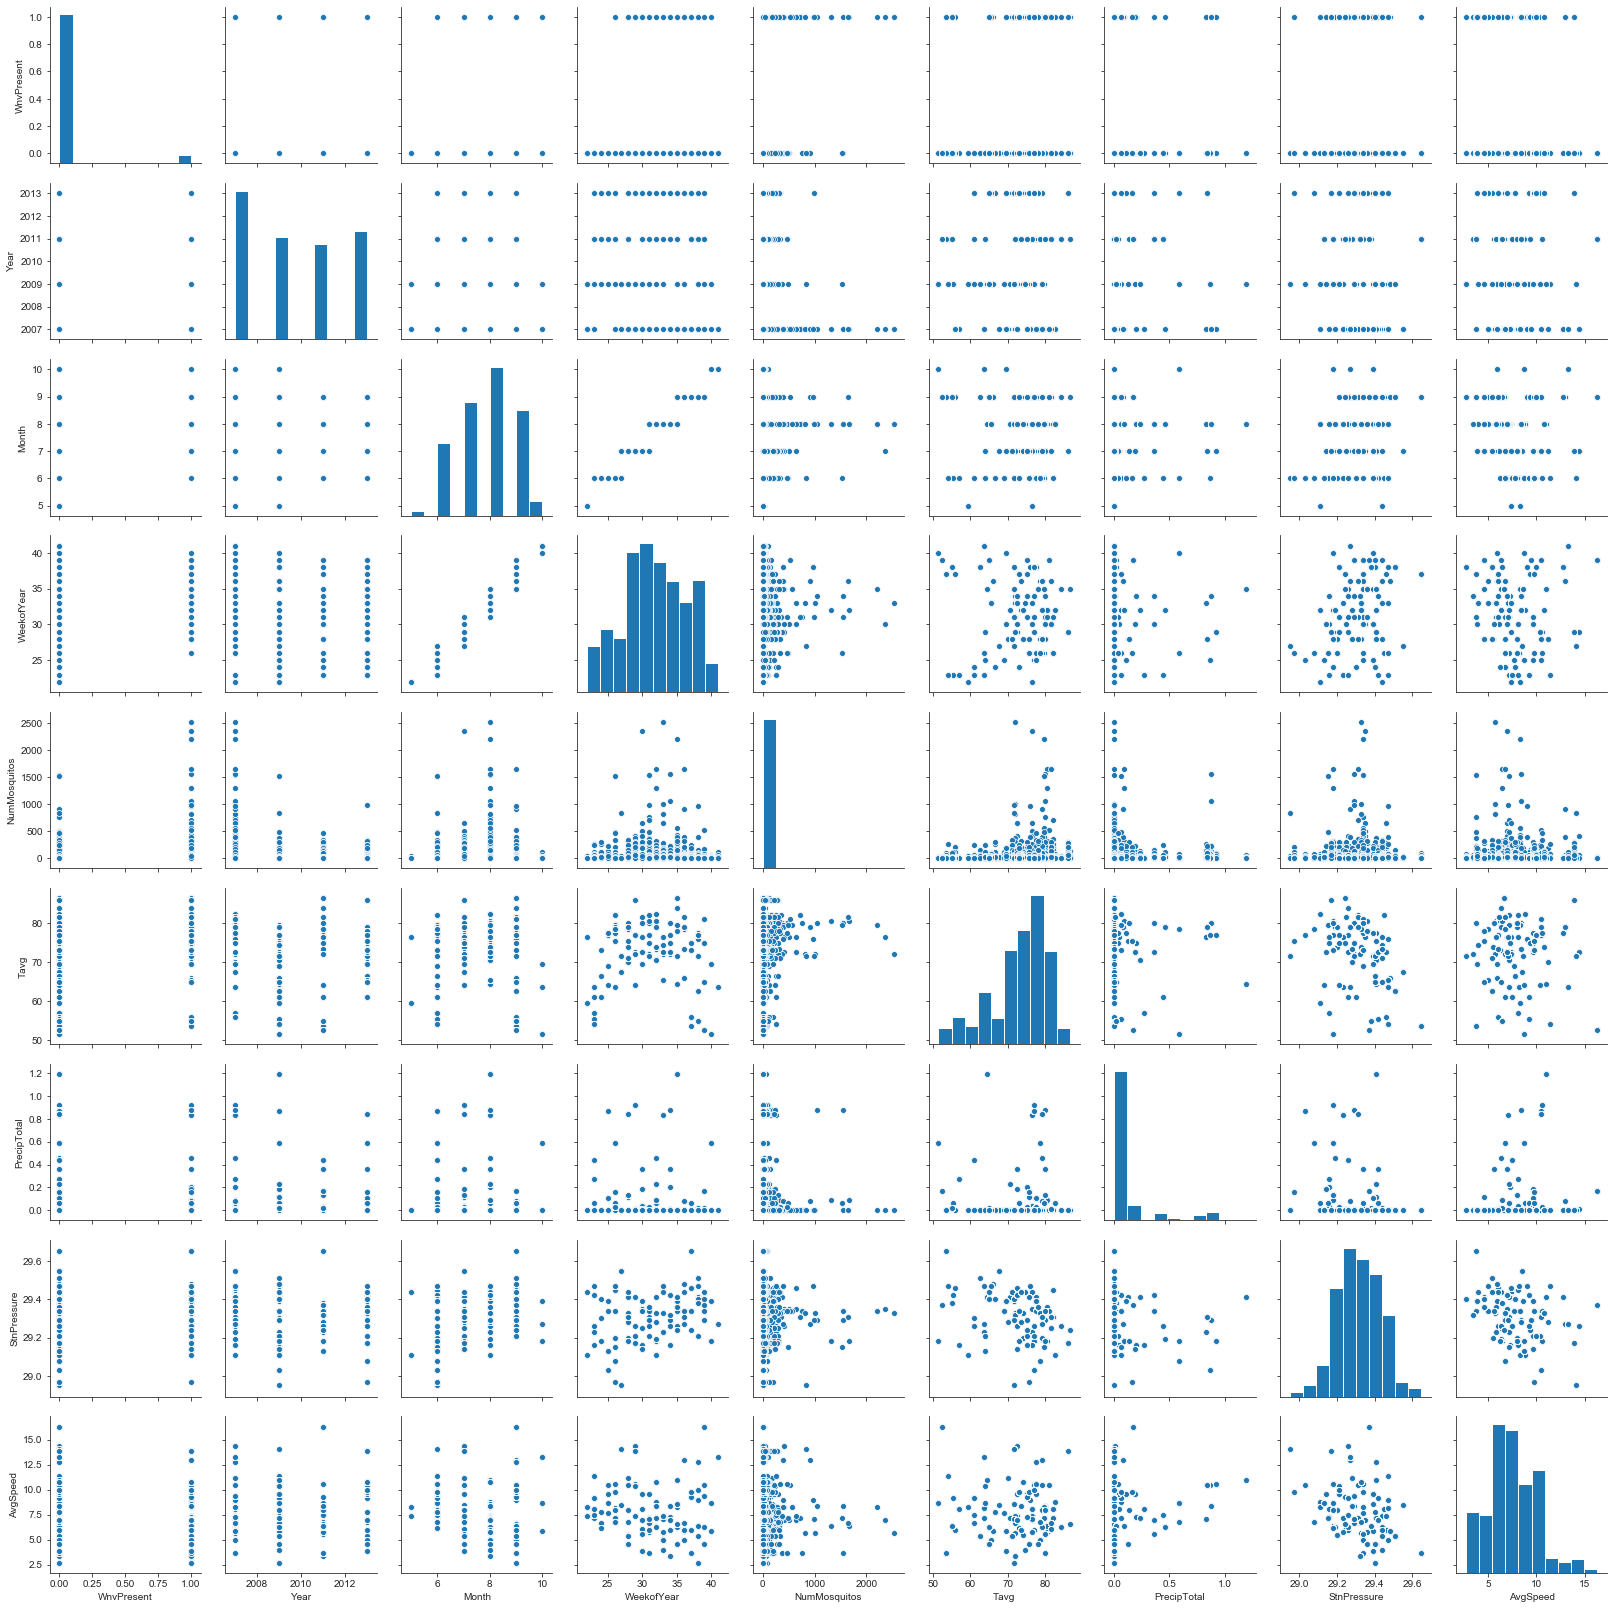

In [100]:
sns.pairplot(combined[['WnvPresent','Year','Month','WeekofYear','NumMosquitos','Tavg',\
                       'PrecipTotal','StnPressure','AvgSpeed']])

#### Correlation heatmap

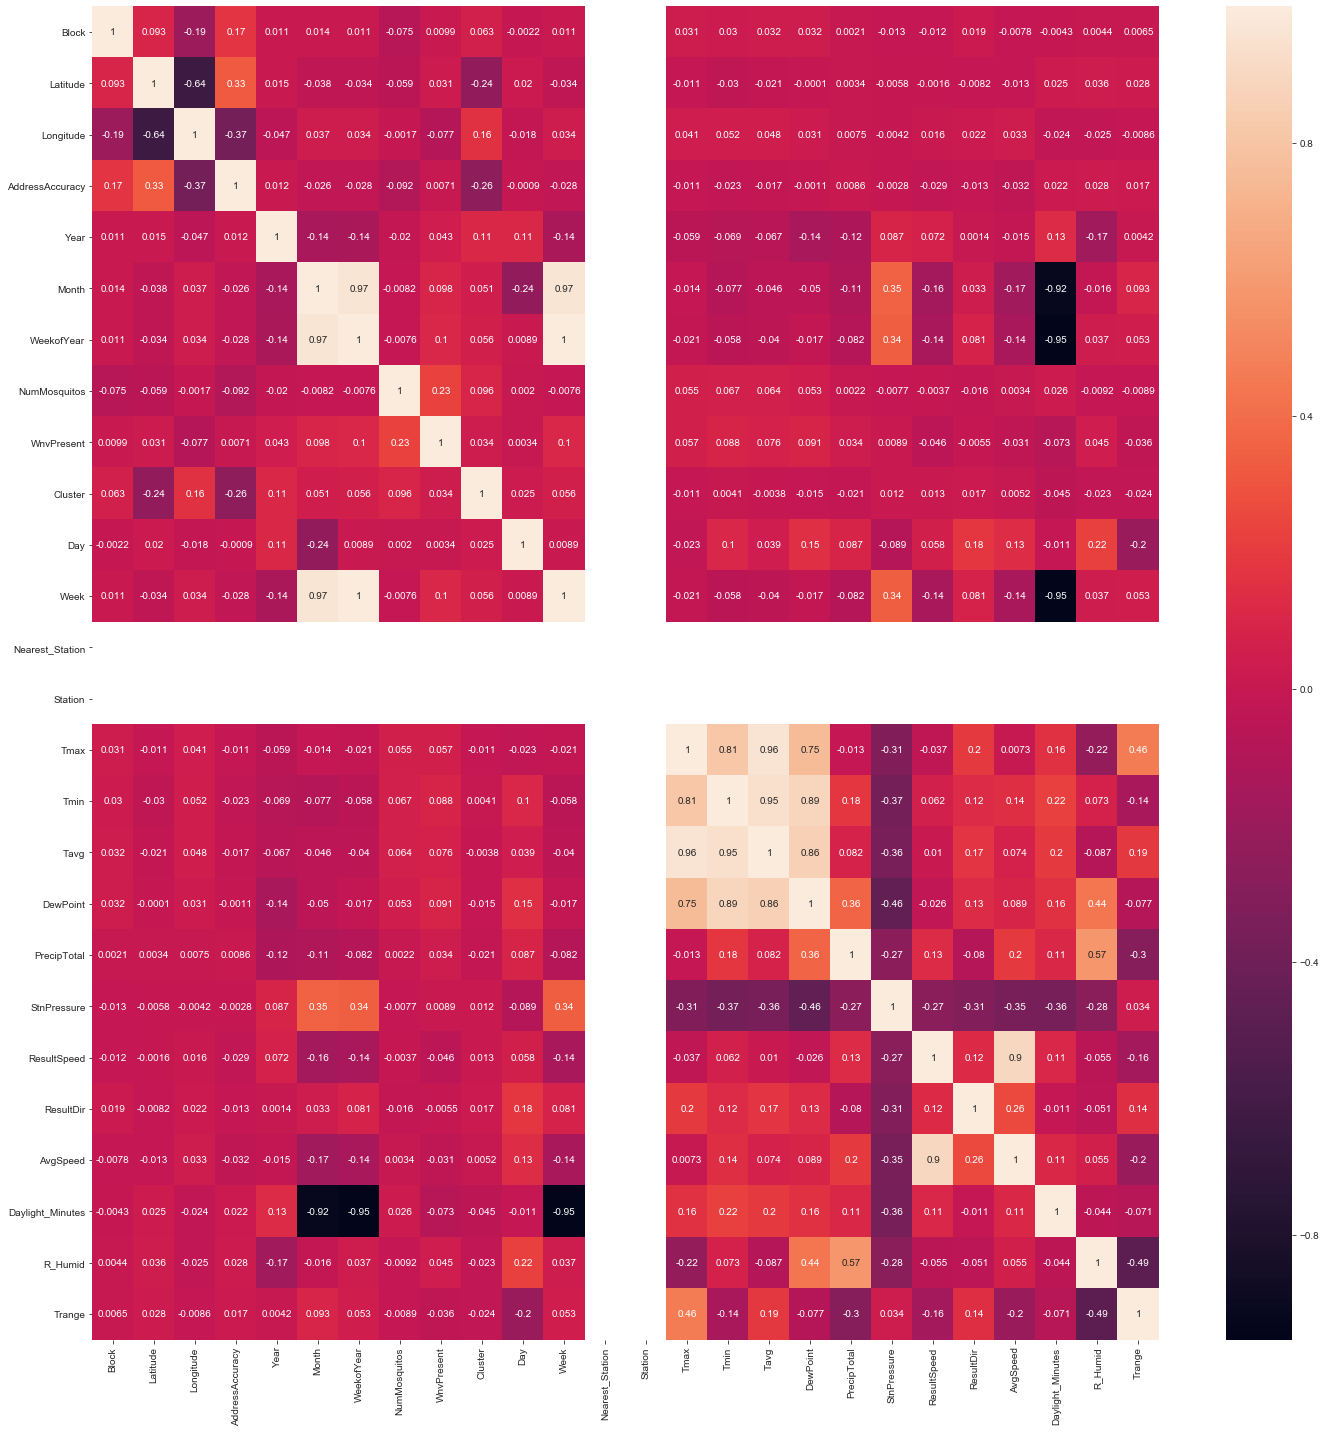

In [101]:
plt.figure(figsize=(20,20))
sns.heatmap(combined.corr(), annot = True)
plt.tight_layout()

From the pairplot and heatmap, there are no obvious correlation probably due to the nature of an imbalance dataset.

#### Map

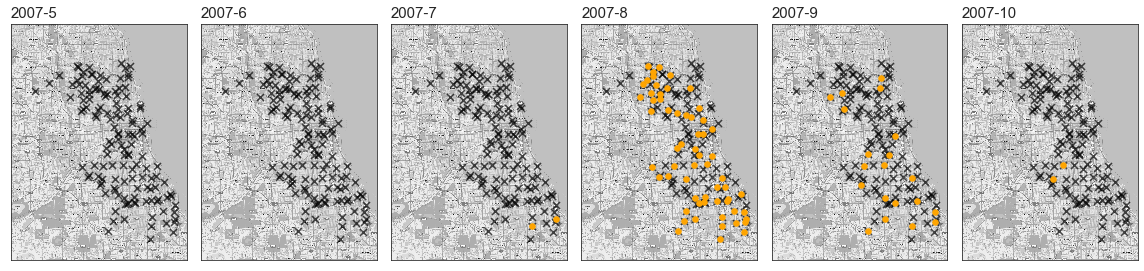

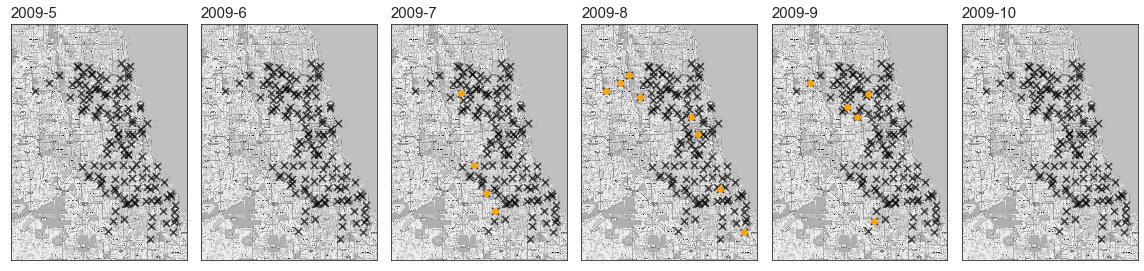

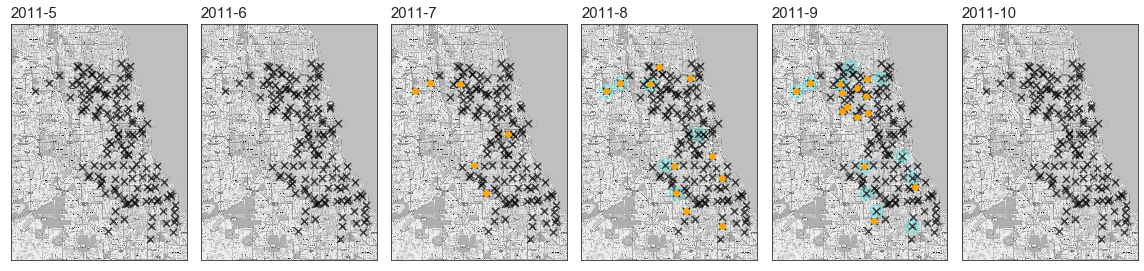

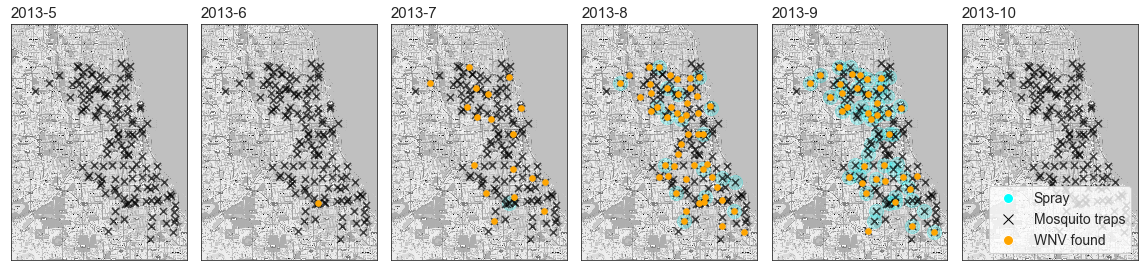

In [102]:
# plot spray data
spray1['year'] = spray1.Date.apply(lambda x:x.year)
spray1['month'] = spray1.Date.apply(lambda x:x.month)

# set up basemap
mapdata = np.loadtxt("./assets/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# create plot for each month and year 
for year in combined.Year.unique():
    fig, ax = plt.subplots(ncols = 6, figsize = (16,5))
    
    for i, month in enumerate([5,6,7,8,9,10]):
        # plot basemap
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        
        # plot spray locations for year and month
        if year in spray1.year.unique() and month in spray1.month.unique():
            sprayed = spray1[(spray1.year == year) & (spray1.month == month)][['Longitude', 'Latitude']].drop_duplicates().values
            ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'cyan', s = 200, alpha = 0.2)
        
        # plot trap locations
        locations = combined[['Longitude', 'Latitude']].drop_duplicates().values
        ax[i].scatter(locations[:,0], locations[:,1], marker='x', c = 'black', s=50, alpha = 0.7)
        
        # plot wnv locations for year and month
        wnv = combined[(combined.Year == year) & (combined.Month == month) & (combined.WnvPresent == 1)]\
                [['Longitude', 'Latitude']].drop_duplicates().values
        ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'orange', s = 30)
        
        # title and axes
        ax[i].set_title(f"{year}-{month}", fontsize = 15, ha = 'left', position = (0,1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        plt.tight_layout()
#         plt.savefig(f'heatmap_{year}_{month}')

# custom legend
legend_elements=[Line2D([0],[0],marker='o', color='w',label='Spray', markerfacecolor='cyan', markersize=10),
                 Line2D([0],[0],marker='x', color='black', label='Mosquito traps',linestyle='', markersize=10),
                 Line2D([0],[0],marker='o', color='w',label='WNV found',markerfacecolor='orange', markersize=10)]

plt.legend(handles=legend_elements, loc='lower right', fontsize=14)
plt.tight_layout()

From the map above, it is clear that the presence of WNV almost always increase from July and peak in the month of August where the temperature is 68 to 75 degrees Fahrenheit. From our research, mosquitoes seem to breed faster but also die faster at a higher temperature. Although, we do not have the upper and lower limit of the temperature where it stops affecting the life cycle of mosquitoes, there isn't much discrepancy in the temperature year over year.

To our surprise, wind speed does seem to affect the number of WNV present with the exception of August 2009, the mean monthly wind speed are usually low in August.

# Preprocessing

In [103]:
def weather_moving_average(df, cols_mean, cols_sum, start, end):
    
    suffix = ''.join(['_', str(start), '_', str(end)])
   
    stations = df['Station'].unique()
    
    cols_mean_name = [cols + '_mean' + suffix for cols in cols_mean]
    cols_sum_name = [cols + '_sum' + suffix for cols in cols_sum]
    
    new_cols = []
    new_cols.extend(cols_mean_name)
    new_cols.extend(cols_sum_name)
    new_cols.extend(['Date_Station'])
      
    df_rolling = pd.DataFrame(None, columns = new_cols)
    
    for station in stations:
        station_mean = df.loc[(df['Station'] == station), cols_mean].rolling(end - start).mean().shift(start)
        station_mean.columns = cols_mean_name
        
        station_sum = df.loc[(df['Station'] == station), cols_sum].rolling(end - start).sum().shift(start)
        station_sum.columns = cols_sum_name
        
        df_station = pd.concat([station_mean, station_sum], axis = 1)
        df_station['Date_Station'] = df.loc[(df['Station'] == station), 'Date_Station']
        
        df_rolling = df_rolling.append(df_station)
            
    return df_rolling


In [104]:
# define preprocessing function

def preprocess_train(trap_df, trap_cols_copy, trap_cols_dummy, weather_df, cols_mean, cols_sum, start, end, cluster_map):
    
    # ---------------------------------- MAKE NEW COLUMNS -------------------------------------
    
    df_preprocess = trap_df.copy()
    
    # datetime
    df_preprocess['Year'] = df_preprocess['Date'].apply(lambda x:x.year)
    df_preprocess['Month'] = df_preprocess['Date'].apply(lambda x:x.month)
    df_preprocess['YearMonth'] = df_preprocess['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
    df_preprocess['WeekofYear'] = df_preprocess['Date'].apply(lambda x:x.weekofyear)
    df_preprocess['DayofYear'] = df_preprocess['Date'].apply(lambda x:x.dayofyear)

    # locations
    df_preprocess['LatLong'] = [(x, y) for x, y in zip(df_preprocess['Latitude'], df_preprocess['Longitude'])]
    df_preprocess['Coord'] = [Point(x, y) for x, y in zip(df_preprocess['Latitude'], df_preprocess['Longitude'])]
    
    
    # ---------------------------------- JOIN WITH WEATHER -------------------------------------
    station_points = MultiPoint([Point(41.995, -87.933), Point(41.786, -87.752)])
    df_preprocess['Nearest_Station'] = df_preprocess['Coord'].map(lambda x : 1 if nearest_points(station_points, x)[0] == station_points[0] else 2)
    df_preprocess['Date_Station'] = df_preprocess['Date'].astype(str) + '_' + df_preprocess['Nearest_Station'].astype(str)
    
    # combine with weather
    df_weather_roll = weather_moving_average(weather_df, cols_mean, cols_sum, start, end)
    
    preprocess_cols = trap_cols_copy.copy()
    preprocess_cols.extend(trap_cols_dummy)
    preprocess_cols.extend(['Date_Station', 'LatLong', 'WnvPresent'])
    df_preprocess = df_preprocess[preprocess_cols]

    if cluster_map != None:
        df_preprocess['Cluster'] = df_preprocess['LatLong'].map(cluster_map)
        df_preprocess = pd.get_dummies(df_preprocess, columns = ['Cluster'])
        
    df_preprocess = pd.get_dummies(df_preprocess, columns = trap_cols_dummy)
    
    df_preprocess = df_preprocess.merge(df_weather_roll, on = 'Date_Station').drop(columns = 'Date_Station')
    
    if 'LatLong' not in trap_cols_copy and 'LatLong' not in trap_cols_dummy:
        df_preprocess = df_preprocess.drop(columns = 'LatLong')
    
    return df_preprocess



In [105]:
# define preprocessing function

def preprocess_test(test_df, preprocess_train, trap_cols_copy, trap_cols_dummy, weather_df, cols_mean, \
                    cols_sum, start, end, cluster_map, trap_df):
    
    # ---------------------------------- MAKE NEW COLUMNS -------------------------------------
    
    df_preprocess = test_df.copy()
    
    # datetime
    df_preprocess['Year'] = df_preprocess['Date'].apply(lambda x:x.year)
    df_preprocess['Month'] = df_preprocess['Date'].apply(lambda x:x.month)
    df_preprocess['YearMonth'] = df_preprocess['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
    df_preprocess['WeekofYear'] = df_preprocess['Date'].apply(lambda x:x.weekofyear)
    df_preprocess['DayofYear'] = df_preprocess['Date'].apply(lambda x:x.dayofyear)

    # locations
    df_preprocess['LatLong'] = [(x, y) for x, y in zip(df_preprocess['Latitude'], df_preprocess['Longitude'])]
    df_preprocess['Coord'] = [Point(x, y) for x, y in zip(df_preprocess['Latitude'], df_preprocess['Longitude'])]
    
    
    # ---------------------------------- JOIN WITH WEATHER -------------------------------------
    station_points = MultiPoint([Point(41.995, -87.933), Point(41.786, -87.752)])
    df_preprocess['Nearest_Station'] = df_preprocess['Coord'].map(lambda x : 1 if nearest_points(station_points, x)[0] == station_points[0] else 2)
    df_preprocess['Date_Station'] = df_preprocess['Date'].astype(str) + '_' + df_preprocess['Nearest_Station'].astype(str)
    
    # combine with weather
    df_weather_roll = weather_moving_average(weather_df, cols_mean, cols_sum, start, end)
    
    preprocess_cols = trap_cols_copy.copy()
    preprocess_cols.extend(trap_cols_dummy)
    preprocess_cols.extend(['Date_Station', 'LatLong'])
    df_preprocess = df_preprocess[preprocess_cols]
    
    if cluster_map != None:
        knn = KNeighborsClassifier(n_neighbors = 1)
        trap_df['LatLong'] = [(x, y) for x, y in zip(trap_df['Latitude'], trap_df['Longitude'])]
        trap_df['Cluster'] = trap_df['LatLong'].map(cluster_map)
        knn.fit(trap_df[['Latitude', 'Longitude']], trap_df['Cluster'])
        df_preprocess[['Latitude', 'Longitude']] = test_df[['Latitude', 'Longitude']]
        df_preprocess['Cluster'] = knn.predict(df_preprocess[['Latitude', 'Longitude']])
        df_preprocess = pd.get_dummies(df_preprocess, columns = ['Cluster'])

        if 'Latitude' not in trap_cols_copy and 'Latitude' not in trap_cols_dummy:
            df_preprocess = df_preprocess.drop(columns = 'Latitude')
        if 'Longitude' not in trap_cols_copy and 'Longitude' not in trap_cols_dummy:
            df_preprocess = df_preprocess.drop(columns = 'Longitude')
        
    df_preprocess = pd.get_dummies(df_preprocess, columns = trap_cols_dummy)
    
    df_preprocess = df_preprocess.merge(df_weather_roll, on = 'Date_Station').drop(columns = 'Date_Station')
    


    if 'LatLong' not in trap_cols_copy and 'LatLong' not in trap_cols_dummy:
        df_preprocess = df_preprocess.drop(columns = 'LatLong')
        
    
    preprocess_train, df_preprocess = preprocess_train.align(df_preprocess, join = 'outer', fill_value = 0, axis = 1)
    
    return preprocess_train, df_preprocess



In [106]:
roll_dict = {
    1 : [['WeekofYear', 'DayofYear', 'Month', 'Latitude', 'Longitude'], ['Species'], \
         ['Tavg', 'Trange', 'DewPoint', 'StnPressure', 'AvgSpeed', 'R_Humid'], ['PrecipTotal', 'Daylight_Minutes'], \
         0, 10],
    2 : [['WeekofYear', 'DayofYear', 'Month', 'Latitude', 'Longitude'], ['Species'], \
         ['Tavg', 'Trange', 'DewPoint', 'StnPressure', 'AvgSpeed', 'R_Humid'], ['PrecipTotal', 'Daylight_Minutes'], \
         0, 14],
    3 : [['WeekofYear', 'DayofYear', 'Month', 'Latitude', 'Longitude'], ['Species'], \
         ['Tavg', 'Trange', 'DewPoint', 'StnPressure', 'AvgSpeed', 'R_Humid'], ['PrecipTotal', 'Daylight_Minutes'], \
         0, 18],
}


df_dict = {}

df_dict_names = {
    1 : 'Rolling 10 days',
    2 : 'Rolling 14 days',
    3 : 'Rolling 18 days'
}



In [114]:
# process train data
trap_pre = pd.read_csv('../assets/train.csv', parse_dates=['Date'])
test_pre = pd.read_csv('../assets/test.csv', index_col=0, parse_dates =['Date'])

for i in roll_dict.keys():
    df_dict[i] = {}
    df_dict[i]['name'] = df_dict_names[i]
    df_dict[i]['train'] = preprocess_train(trap_pre.copy(), roll_dict[i][0], roll_dict[i][1], weather, \
                                           roll_dict[i][2], roll_dict[i][3], roll_dict[i][4], roll_dict[i][5], \
                                           cluster_dict)
    df_dict[i]['train'], df_dict[i]['test'] = preprocess_test(test_pre.copy(), df_dict[i]['train'].copy(), roll_dict[i][0], \
                                                              roll_dict[i][1], weather, roll_dict[i][2], roll_dict[i][3], \
                                                              roll_dict[i][4], roll_dict[i][5], cluster_dict, \
                                                              trap_pre.copy())


In [115]:
# process test data

df_processed = pd.DataFrame(df_dict)
df_processed.to_pickle('../assets/processed.zip')